In [1]:
# Version check. Written for Python 3.5.4
import sys
print(sys.version)
#3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
#[GCC 7.2.0]

import matplotlib
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sympy import *
from sympy.utilities.autowrap import autowrap
import re
import numpy.fft as fft
from scipy.signal import argrelextrema
import random
import warnings
from matplotlib.lines import Line2D

%matplotlib inline

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
# Define the path to the input folder containing the output parameters
inputFolder = "/Users/muriel/Documents/LACDR/Projects/E2S/Modeling/Output/E2Model/version2/MN10/E2/20221230_165912/"#M010/E2/20220613_171703/" # Write down the path to the folder that
# contains the parameter estimates of all the finished runs

# Define the path to the parameter estimates
filename = "20221230_165912_MH_MN10Model_parameterEstimates_parmset1_cost_294.44.csv"

# Read in the file with the parameter estimates
file = inputFolder+filename

In [3]:
# Original initial states
CDK1_init = 0.32
APC_init = 0.07

# Parameters
a1 = 0.02
a2 = 3
a3 = 3

b1 = 3
b2 = 1

K1 = 0.5
K2 = 0.5
K3 = 0.5

n1 = 8
n2 = 8
n3 = 8

In [4]:
# Read in the file with the parameter estimates
file = inputFolder+filename

# Define the parameters
parameterEst = pd.read_csv(file)

pAllNew = parameterEst["est_value"].values

# Make the parameters global variables
for i in parameterEst.iterrows():
    sText = str(parameterEst.iloc[i[0], 0]) + " = " + str(parameterEst.iloc[i[0], 2])
    print(sText)
    exec(sText)

CONC2_init = 0.042460989840139934
CONC3_init = 0.1659808914688818
CONC4_init = 0.2366562074735528
CONC5_init = 0.3743171777243467
CONC6_init = 0.8372565041030933
ER_init = 0.12604737829819276
PR_init = 0.7941287753443627
GREB1_init = 0.9134348990318942
TFF1_init = 0.9671899408866416
d_er = 0.02227131880644441
d_pr = 0.06562196867299717
d_greb1 = 0.3725773184940744
d_tff1 = 0.0
b_e2er = 0.9999999999
d_e2er = 0.24597683777854515
b_e2erpr = 0.025412532897680137
d_e2erpr = 0.8141993330728129
b_e2erprgreb1 = 0.9999999527096904
d_e2erprgreb1 = 0.004810306600735929
stim_pr = 67.69653835443742
stim_greb1 = 999.9999981621162
stim_tff1 = 10.469512336084826
s_er = 0.002807241346795553
s_pr = 0.05211229361797338
s_greb1 = 0.34032512530020875
s_tff1 = 0.0


In [5]:
CONC1_init = 0.001
Ce2er_init = 0
Ce2erpr_init = 0
Ce2erprgreb1_init = 0

In [6]:
# PART 1: constant oscillations
def CellCycle_default(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2er * PR
    
    # E2 signaling
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


In [7]:
# Recalculate steady state constraints
s_er = d_er * ER_init
s_pr = d_pr * PR_init 
s_greb1 = d_greb1 * GREB1_init
s_tff1 = d_tff1 * TFF1_init

s_er, s_pr, s_greb1, s_tff1

(0.0028072413467955535, 0.05211229361797338, 0.34032512530020875, 0.0)

In [8]:
# Additional parameters
k_greb1 = 1#0.01
r = 1#100 # range 100-500

In [9]:
# Check steady states

# E2 signaling
dE2 = - b_e2er * 0 * ER_init / (1 + 0 + ER_init)
dER = s_er - b_e2er * 0 * ER_init / (1 + 0 + ER_init) - d_er * ER_init
dCe2er = b_e2er * 0 * ER_init / (1 + 0 + ER_init) - b_e2erpr * Ce2er_init * PR_init / (1 + Ce2er_init + PR_init) - d_e2er * Ce2er_init

# Formation of second complex
dPR = s_pr + stim_pr * Ce2erprgreb1_init / (1 + Ce2erprgreb1_init) - b_e2erpr * Ce2er_init * PR_init / (1 + Ce2er_init + PR_init) - d_pr * PR_init
dCe2erpr = b_e2erpr * Ce2er_init * PR_init / (1 + Ce2er_init + PR_init) - b_e2erprgreb1 * Ce2erpr_init * GREB1_init / (1 + Ce2erpr_init + GREB1_init) - d_e2erpr * Ce2erpr_init

# Formation of third complex
dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr_init * GREB1_init / (1 + Ce2erpr_init + GREB1_init) + stim_greb1 * Ce2erprgreb1_init / (1 + Ce2erprgreb1_init) - d_greb1 * GREB1_init
dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr_init * GREB1_init / (1 + Ce2erpr_init + GREB1_init) - d_e2erprgreb1 * Ce2erprgreb1_init
dTFF1 = s_tff1 + stim_tff1 * Ce2er_init * PR_init  / (1 + Ce2er_init + PR_init) - d_tff1 * TFF1_init

# print outcome
dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1


(-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [10]:
# PART 0: Run simulation and save output for plotting in R. 

# Initial conditions
z_part0 = [CDK1_init, APC_init, CONC1_init, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]

# PART 1 time span 
t_part0 = np.linspace(1, 55, 55)

# Run simulation
out_part0 = odeint(CellCycle_default, z_part0, t_part0)

d = {'dose_nM': np.repeat(0.001,55*3), 'timeID': np.hstack(np.repeat([np.arange(1,56,1)],3, axis = 0)), "StateVar": ["GREB1"]*55 + ["PR"]*55 + ["TFF1"]*55,
    "GFP": np.hstack((out_part0[:,7]+out_part0[:,8],out_part0[:,5]+out_part0[:,6]+out_part0[:,8],out_part0[:,9]))}

simu_data = pd.DataFrame(data = d)
simulations = [out_part0[:,2::]]

for dose,conc in enumerate([CONC2_init, CONC3_init, CONC4_init, CONC5_init, CONC6_init]):

    # Initial conditions
    z_part0 = [CDK1_init, APC_init, conc, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]

    # PART 1 time span 
    t_part0 = np.linspace(1, 55, 55)

    # Run simulation
    out_part0 = odeint(CellCycle_default, z_part0, t_part0)
    
    nominal_conc = [0.01,0.1,1,10,100][dose]

    d = {'dose_nM': np.repeat(nominal_conc,55*3), 'timeID': np.hstack(np.repeat([np.arange(1,56,1)],3, axis = 0)), "StateVar": ["GREB1"]*55 + ["PR"]*55 + ["TFF1"]*55,
        "GFP": np.hstack((out_part0[:,7]+out_part0[:,8],out_part0[:,5]+out_part0[:,6]+out_part0[:,8],out_part0[:,9]))}
    
    data = pd.DataFrame(data = d)
    
    simu_data = pd.concat([simu_data, data])

    simulations.append(out_part0[:,2::])

simu_data

#simu_data.to_csv("MN10_simu_data.csv")



,dose_nM,timeID,StateVar,GFP
0,0.001,1,GREB1,0.913435
1,0.001,2,GREB1,0.913452
2,0.001,3,GREB1,0.913624
3,0.001,4,GREB1,0.914118
4,0.001,5,GREB1,0.915011
...,...,...,...,...
160,100.000,51,TFF1,6.721506
161,100.000,52,TFF1,6.808944
162,100.000,53,TFF1,6.896556
163,100.000,54,TFF1,6.984335


Text(0, 0.5, 'Simulated intensity (a.u.)')

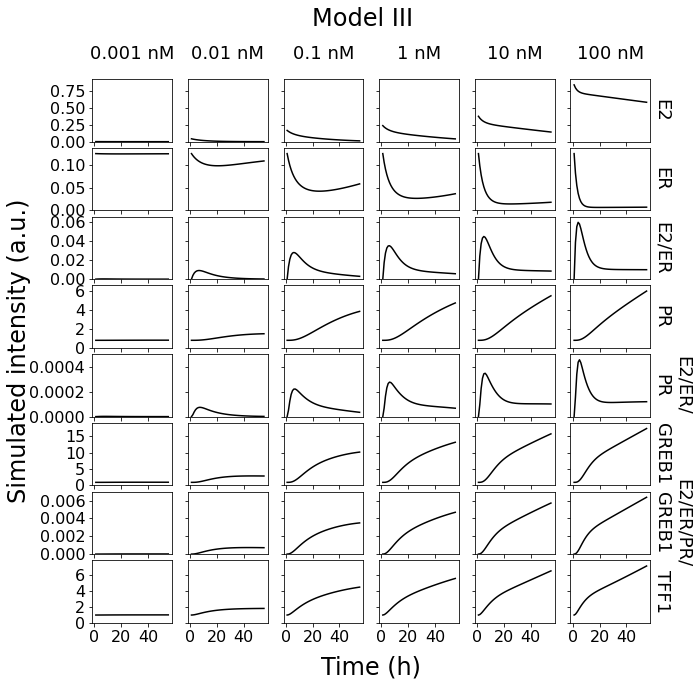

In [11]:
# PART 1.5: Make a figure for inner states of the model simulations
varnames_total = ["E2","ER","E2/ER","PR","E2/ER/\nPR","GREB1","E2/ER/PR/\nGREB1","TFF1"]
doses = ["0.001 nM", "0.01 nM", "0.1 nM", "1 nM", "10 nM", "100 nM"]

nrows = len(varnames_total)
fig, ax = plt.subplots(nrows,len(simulations),sharex=True, sharey='row')

for d, dose in enumerate(doses):
    # Set dose title
    ax[0,d].set_title(dose,fontdict={'fontsize': 18}, pad=20)

    for row in range(0,nrows):
        ax[row, d].set_ylim(ymin = 0, ymax = max(simulations[d][:,row])+0.1*max(simulations[d][:,row]))
        ax[row,d].plot(t_part0,simulations[d][:,row], color = "#000000")
        ax[row, d].tick_params(axis = 'both', labelsize=16)

        ax[row, len(simulations)-1].set_ylabel(varnames_total[row], rotation = -90, fontsize = 18)
        ax[row, len(simulations)-1].yaxis.set_label_coords(1.03,0.5)
        ax[row, len(simulations)-1].locator_params(axis='both', nbins=4)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.suptitle("Model III", fontsize = 24)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=24, labelpad=16)
plt.ylabel("Simulated intensity (a.u.)", fontsize=24, labelpad=38)

#plt.savefig('Figures/MN10/FigS1F_MN10_innerstates.pdf', bbox_inches='tight')



In [12]:
# Fit a line through the effective vs nominal concentrations
nc = np.log(np.array([0.001, 0.01, 0.1, 1, 10, 100]))
ec = np.array([CONC1_init,CONC2_init,CONC3_init,CONC4_init,CONC5_init,CONC6_init])

nc
a,b = np.polyfit(nc, ec, deg = 1)

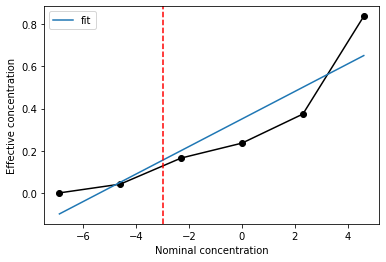

In [13]:
# Plot the effective vs nominal concentration range
fig,ax = plt.subplots()
ax.plot(nc,ec,marker = 'o', color = 'k')
ax.plot(nc, a*nc+b, label = 'fit')

ax.set_xlabel('Nominal concentration')
ax.set_ylabel('Effective concentration')
ax.axvline(x = np.log(0.05), color = "r", linestyle = "--")
ax.legend()



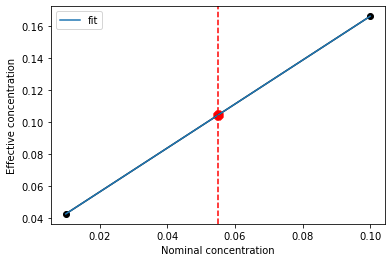

In [14]:
# Dashed red line crossing with blue fit is too high. Choose straight line between 0.01 and 0.1
# Fit a line through the effective vs nominal concentrations
nc = np.array([0.01,0.1])
ec = np.array([CONC2_init,CONC3_init])

nc
a,b = np.polyfit(nc, ec, deg = 1)

# Plot the effective vs nominal concentration range
fig,ax = plt.subplots()
ax.plot(nc,ec,marker = 'o', color = 'k')
ax.plot(nc, a*nc+b, label = 'fit')
ax.scatter(0.055,a*0.055+b, color = "red", marker = "8", s = 100)

ax.set_xlabel('Nominal concentration')
ax.set_ylabel('Effective concentration')
ax.axvline(x = 0.055, color = "r", linestyle = "--")
ax.legend()

EC_t_0 = a*0.055+b
EC_t_min24 = EC_t_0 * 1.5


In [15]:
print(EC_t_0)
print(EC_t_min24)

0.10422094065451092
0.15633141098176637


Text(0, 0.5, 'Proteins')

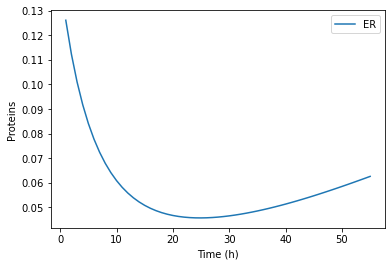

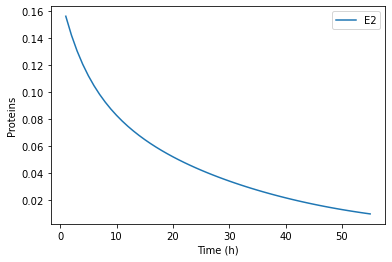

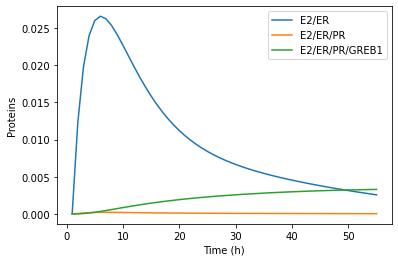

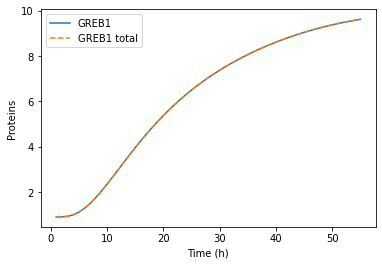

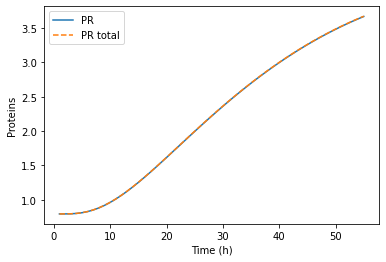

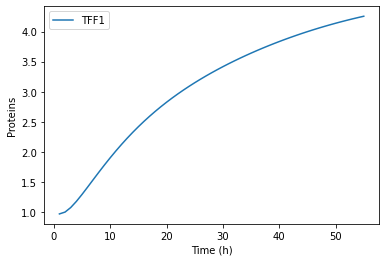

In [16]:
# Initial conditions
z_part0 = [CDK1_init, APC_init, EC_t_min24, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]

# PART 1 time span 
t_part0 = np.linspace(1, 55, 55)

# Run simulation
out_part0 = odeint(CellCycle_default, z_part0, t_part0)

# PART 0 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part0,out_part0[:,3],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part0,out_part0[:,2],label='E2', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part0,out_part0[:,4],label='E2/ER', linestyle = 'solid')
ax.plot(t_part0,out_part0[:,6],label='E2/ER/PR', linestyle = 'solid')
ax.plot(t_part0,out_part0[:,8],label='E2/ER/PR/GREB1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part0, out_part0[:,7], label='GREB1', linestyle = 'solid') 
ax.plot(t_part0,out_part0[:,7] + out_part0[:,8], label='GREB1 total', linestyle = 'dashed') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part0,out_part0[:,5], label='PR', linestyle = 'solid') 
ax.plot(t_part0,out_part0[:,5] + out_part0[:,6] + out_part0[:,8], label='PR total', linestyle = 'dashed') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part0,out_part0[:,9],label='TFF1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')




Frequency = 0.020000
Period = 50.000000


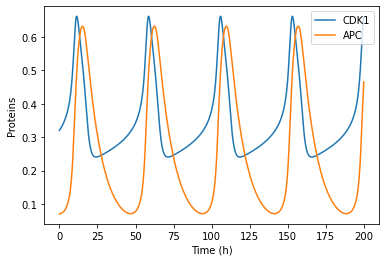

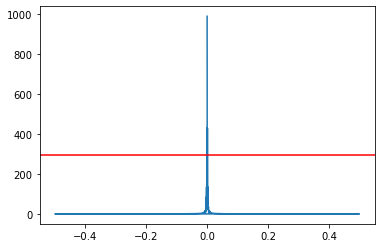

In [17]:
# Test phase: default oscillations

# Initial states
CDK1_init = 0.32
APC_init = 0.07

# Parameters
# Divide original values by 11 to get a period/cell cycle duration of 50 hrs.
a1 = 0.02/11
a2 = 3/11
a3 = 3/11

b1 = 3/11
b2 = 1/11

K1 = 0.5
K2 = 0.5
K3 = 0.5

n1 = 8
n2 = 8
n3 = 8

# Model
def CellCycle_orig(z,t):    
    
    # State vars
    CDK1, APC  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3))
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * APC
    
    return [dCDK1, dAPC]

# Initial conditions
z_phase1 = np.array((0.32,0.07))

# Time range
timespan_test = 200
timepoints_test = 4000

# Phase 1 time span 
t_phase1 = np.linspace(0, timespan_test, timepoints_test)

# Run simulation
out_test = odeint(CellCycle_orig, z_phase1, t_phase1)

# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_test[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_phase1,out_test[:,1],label='APC', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Get period
spectrum = fft.fft(out_test[::,1])
freq = fft.fftfreq(len(spectrum))
threshold = 0.3 * max(abs(spectrum))

fig,ax = plt.subplots()
ax.plot(freq, abs(spectrum))
ax.axhline(y = threshold, color = 'red')

mask = abs(spectrum) > threshold
peaks = freq[mask]
frate = timepoints_test/timespan_test
frequency = max(abs(peaks*(frate)))
print("Frequency = %f" % frequency)
period = 1/frequency
print("Period = %f" % period)



Text(0, 0.5, 'Proteins')

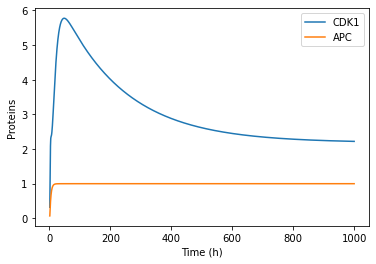

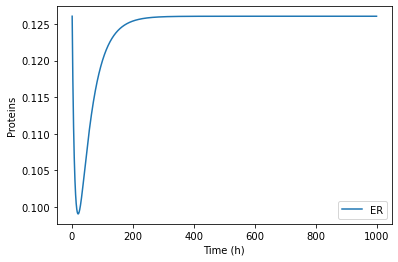

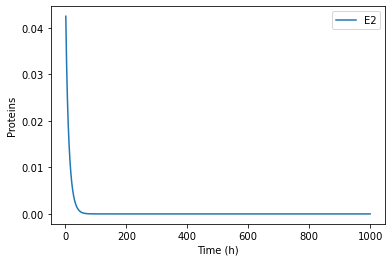

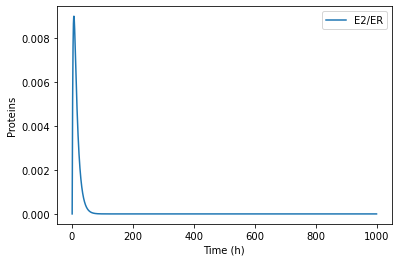

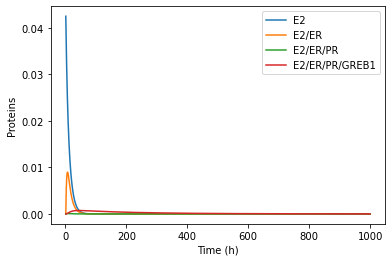

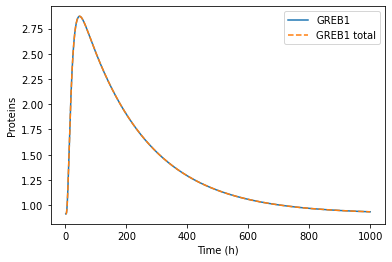

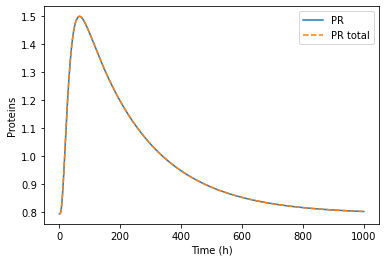

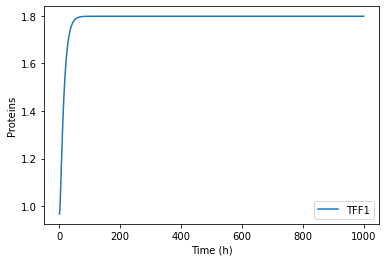

In [18]:
# PART 1: simulations for long period, to see if protein levels return to initial state
# Initial conditions
z_part1 = [CDK1_init, APC_init, CONC2_init, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]

# PART 1 time span 
t_part1 = np.linspace(1, 1000, 8000)

# Run simulation
out_part1 = odeint(CellCycle_default, z_part1, t_part1)

# PART 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,1],label='APC', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,3],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,2],label='E2', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,4],label='E2/ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,2],label='E2', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,4],label='E2/ER', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,6],label='E2/ER/PR', linestyle = 'solid')
ax.plot(t_part1,out_part1[:,8],label='E2/ER/PR/GREB1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1, out_part1[:,7], label='GREB1', linestyle = 'solid') 
ax.plot(t_part1,out_part1[:,7] + out_part1[:,8], label='GREB1 total', linestyle = 'dashed') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,5], label='PR', linestyle = 'solid') 
ax.plot(t_part1,out_part1[:,5] + out_part1[:,6] + out_part1[:,8], label='PR total', linestyle = 'dashed') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part1,out_part1[:,9],label='TFF1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



Frequency = 0.020750
Period = 48.192771


Text(0, 0.5, 'Proteins')

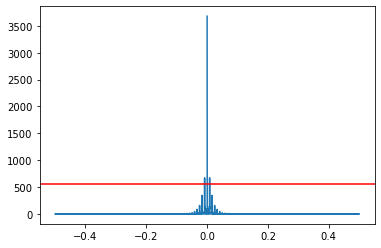

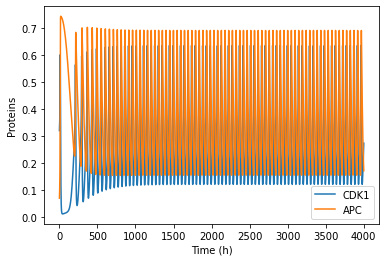

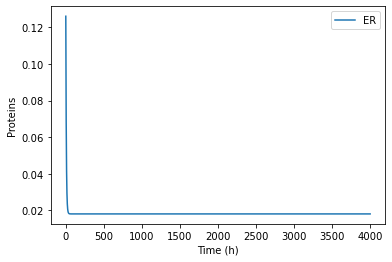

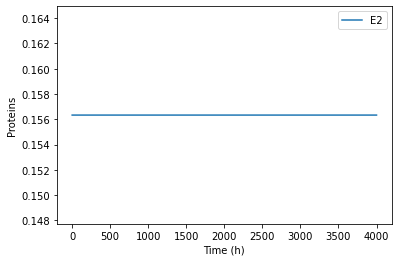

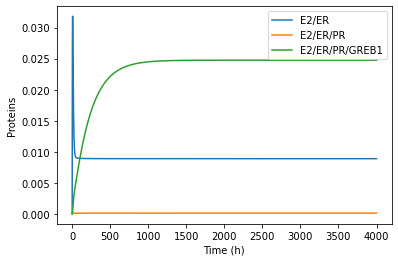

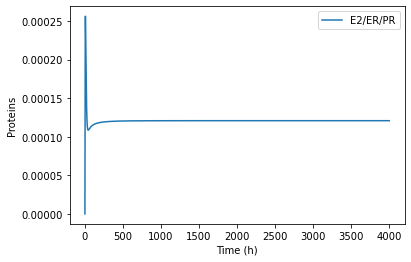

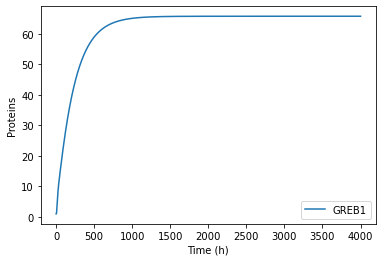

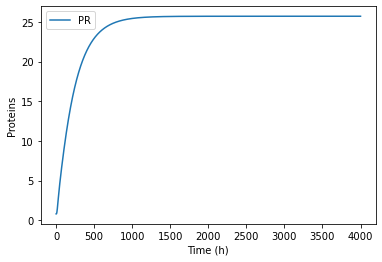

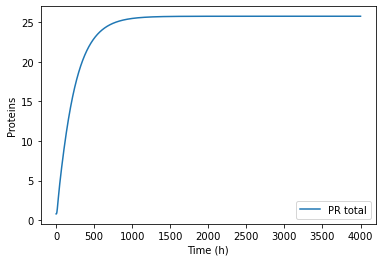

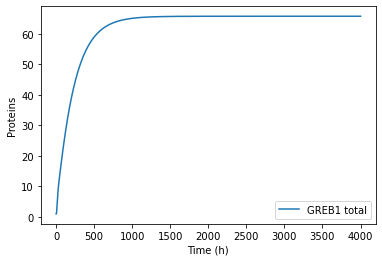

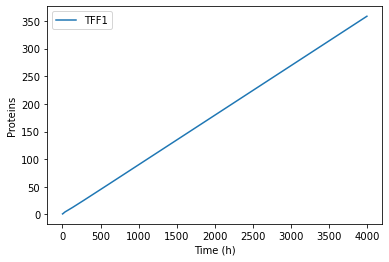

In [51]:
# PART 2: simulations to see whether at constant E2, proteins go to a new equilibrium.

# Additional parameters
k_greb1 = 0.0001 # 0.0001 for CONC2_init * 1.5
r = 0.8 # 2.2 # 6.5 for CONC2_init * 1.5

# Model
def CellCycle_constant(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = 0
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]

# Initial conditions
z_part2 = [CDK1_init, APC_init, EC_t_min24, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]

# Time range
timespan_part2 = 4000
timepoints_part2 = 10000

# PART 2 time span 
t_part2 = np.linspace(1, timespan_part2, timepoints_part2)

# Run simulation
out_part2 = odeint(CellCycle_constant, z_part2, t_part2)

# Get period
spectrum = fft.fft(out_part2[::,1])
freq = fft.fftfreq(len(spectrum))
threshold = 0.15 * max(abs(spectrum)) # 0.2 * max(abs(spectrum))

fig,ax = plt.subplots()
ax.plot(freq, abs(spectrum))
ax.axhline(y = threshold, color = 'red')

mask = abs(spectrum) > threshold
peaks = freq[mask]
frate = timepoints_part2/timespan_part2
frequency = max(abs(peaks*(frate)))
print("Frequency = %f" % frequency)
period_part2 = 1/frequency
print("Period = %f" % period_part2)


# PART 2 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_part2,out_part2[:,1],label='APC', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,3],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,2],label='E2', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,4],label='E2/ER', linestyle = 'solid')
ax.plot(t_part2,out_part2[:,6],label='E2/ER/PR', linestyle = 'solid')
ax.plot(t_part2,out_part2[:,8],label='E2/ER/PR/GREB1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,6],label='E2/ER/PR', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2, out_part2[:,7], label='GREB1', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,5], label='PR', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,5] + out_part2[:,6] + out_part2[:,8], label='PR total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,7] + out_part2[:,8], label='GREB1 total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_part2,out_part2[:,9],label='TFF1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

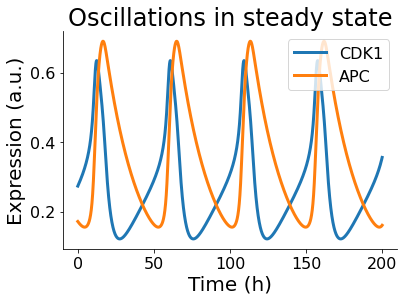

In [53]:
#### Model simulation in steady state
def CellCycle_phase0(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = 0 # - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]

# Initial conditions
z_phase0 = out_part2[out_part2.shape[0]-1,::]

# Make time range
timespan_phase0 = 200 # period_part2
timepoints_phase0 = 4000

# Phase 1 time span 
t_phase0 = np.linspace(0, timespan_phase0, timepoints_phase0)

# Run simulation
out_phase0 = odeint(CellCycle_phase0, z_phase0, t_phase0)

# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,0],label='CDK1', linestyle = 'solid', linewidth = 3)
ax.plot(t_phase0,out_phase0[:,1],label='APC', linestyle = 'solid', linewidth = 3)

ax.legend()
ax.set_title('Oscillations in steady state', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('Expression (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='upper right', prop={'size': 16}) #, bbox_to_anchor=(1, 0.5)


Bifurcation analysis

In [88]:
def model_k_greb1(z,t,p):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    k_greb1 = p
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2er * PR
    
    # E2 signaling
    dE2 = 0 # - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]

def bifurcate_k_greb1(seed:float, n_skip:int, n_iter:int, step:float=0.0001, p_min:float=0.0, p_max:float = 1, pos = 0, prot = "", fig_nr = ""):
    P = []
    V = []
    _range = np.linspace(p_min, p_max, int(1/step))
    for p in _range:
        v = seed
        t = np.linspace(1, n_skip+n_iter+1, (n_skip+n_iter+1))
        out = odeint(model_k_greb1,z,t,args = (p,))
        for i in range(n_skip+n_iter+1):
            if i >= n_skip:
                P.append(p)
                V.append(v)
            v = out[i,pos]
   
    fig,ax = plt.subplots(figsize=(6,4))
    ax.scatter(P, V, marker='.', color='black')
    ax.set_xlabel('k_greb1', fontsize=20)
    ax.set_ylabel(prot, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='both', labelsize=14)
    ax.xaxis.set_ticks(np.arange(p_min, p_max, 0.0005))
    
    plt.savefig('Figures/MN10/Fig'+ fig_nr + '_' + prot + '_Simulations_steady_state_oscillations.pdf', bbox_inches='tight')
    return np.stack((P, V), axis=-1)

def model_r(z,t,p):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    r = p
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2er * PR
    
    # E2 signaling
    dE2 = 0 # - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


def bifurcate_r(seed:float, n_skip:int, n_iter:int, step:float=0.0001, p_min:float=0.0, p_max:float = 1, pos = 0, prot = "", fig_nr = ""):
    P = []
    V = []
    _range = np.linspace(p_min, p_max, int(1/step))
    for p in _range:
        v = seed
        t = np.linspace(1, n_skip+n_iter+1, (n_skip+n_iter+1))
        out = odeint(model_r,z,t,args = (p,))
        for i in range(n_skip+n_iter+1):
            if i >= n_skip:
                P.append(p)
                V.append(v)
            v = out[i,pos]
   
    fig,ax = plt.subplots(figsize=(6,4))
    ax.scatter(P, V, marker='.', color='black')
    ax.set_xlabel('r', fontsize=20)
    ax.set_ylabel(prot, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='both', labelsize=14)
    ax.xaxis.set_ticks(np.arange(p_min, p_max, 1))
    plt.savefig('Figures/MN10/Fig'+ fig_nr + '_' + prot + '_Simulations_steady_state_oscillations.pdf', bbox_inches='tight')

    return np.stack((P, V), axis=-1)




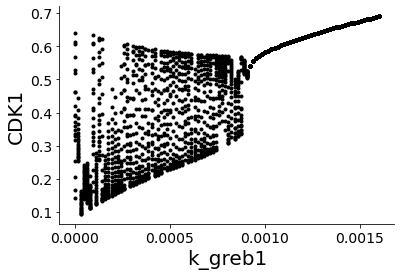

In [60]:
z = z_phase0

bif_res_k_greb1 = bifurcate_k_greb1(seed = 0.2, n_skip = 1000, n_iter = 20, step = 0.01, p_min=0, p_max = 0.0016, pos = 0, prot = "CDK1", fig_nr = "S2A")

In [86]:
bif_res_k_greb1

i = 0
while not (bif_res_k_greb1[i].round(7) == bif_res_k_greb1[i+1].round(7)).all():
    i+=1

i
bif_res_k_greb1[i]

array([0.00092121, 0.54148854])

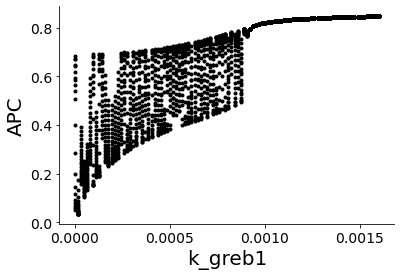

In [50]:
bifurcate_k_greb1(seed = 0.2, n_skip = 1000, n_iter = 20, step = 0.01, p_min=0, p_max = 0.0016, pos = 1, prot = "APC", fig_nr = "S2A")

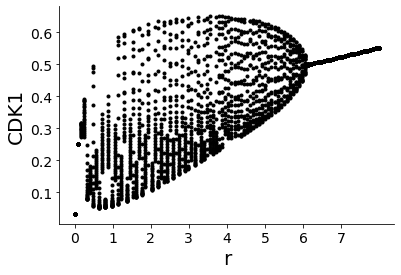

In [98]:
bif_res_r = bifurcate_r(seed = 0.2, n_skip = 1000, n_iter = 20, step = 0.01, p_min=0, p_max = 8, pos = 0, prot = "CDK1", fig_nr = "S2B")

In [96]:
bif_res_r

i = 200
while not (bif_res_r[i].round(7) == bif_res_r[i+1].round(7)).all():
    i+=1

i
print("Higher threshold: ")
bif_res_r[i]

Higher threshold: 


array([6.26226226, 0.50270053])

In [132]:
bif_res_r

i = 200
while not (bif_res_r[i].round(7) == bif_res_r[i-1].round(7)).all():
    i-=1

print(i)
print("Lower threshold: ")
bif_res_r[41]

20
Lower threshold: 


array([0.08080808, 0.25076944])

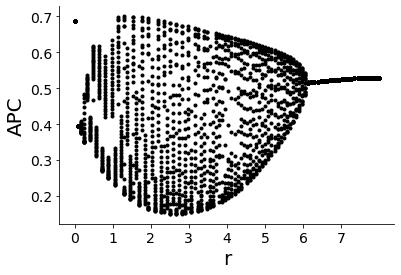

In [49]:
bifurcate_r(seed = 0.2, n_skip = 1000, n_iter = 20, step = 0.01, p_min=0, p_max = 8, pos = 1, prot = "APC", fig_nr = "S2B")

In [59]:
# # Make a plot with color codes

simulation = out_phase0

# for local minima

x_minima_CDK1 = argrelextrema(simulation[::,0], np.less)[0]
y_minima_CDK1 = simulation[x_minima_CDK1,0]

x_minima_APC = argrelextrema(simulation[::,1], np.less)[0]
y_minima_APC = simulation[x_minima_APC,1]

# for local maxima

x_maxima_CDK1 = argrelextrema(simulation[::,0], np.greater)[0]
y_maxima_CDK1 = simulation[x_maxima_CDK1,0]

x_maxima_APC = argrelextrema(simulation[::,1], np.greater)[0]
y_maxima_APC = simulation[x_maxima_APC,1]

print("Minima CDK1 are: ")
print(", ".join(map(str,x_minima_CDK1)))
print("Minima APC are: ")
print(", ".join(map(str,x_minima_APC)))

print("Maxima CDK1 are: ")
print(", ".join(map(str,x_maxima_CDK1)))
print("Maxima APC are: ")
print(", ".join(map(str,x_maxima_APC)))

# Check whether there are sufficient maxima and minima. If not, phase lengths cannot be determined.
if len(x_maxima_APC) == 0 or len(x_minima_CDK1) == 0 or len(x_minima_APC) == 0:
    print("Not enough data to determine phase lengths")
    phase_lengths = []

else:

    # Get the first APC minimum
    first_APC_minimum = y_minima_APC[0]

    # Get the first APC maximum, but if APC starts with a maximum, then take the second maximum 
    # Unless the second maximum does not exist, then take the first maximum
    if x_maxima_APC[0] < x_minima_APC[0] and len(y_maxima_APC) > 1:
        first_APC_maximum = y_maxima_APC[1]
    else:
        first_APC_maximum = y_maxima_APC[0]

    # Calculate the difference between the maximum and minimum
    difference = first_APC_maximum - first_APC_minimum
    print("This is the difference between the first APC maximum and minimum:")
    print(difference)

    # Get threshold for G1S transition
    G1S_thresholds = y_minima_APC + difference * 0.05
    G1S_threshold = G1S_thresholds[0]
    print("G1/S threshold of first minimum:")
    print(G1S_threshold)

    # Get timepoints when APC goes beneath the threshold and increases above it again
    previous = simulation[0,1] < G1S_threshold
    indices_G1S = []
    for j, x in enumerate(simulation[1::,1] < G1S_threshold):
        current = x
        # If there is a switch from False to True, get the index for True
        if current and not previous:
            index = j+1
            indices_G1S.append(index/(timepoints_phase0/timespan_phase0))
        elif not current and previous:
            index = j
            indices_G1S.append(index/(timepoints_phase0/timespan_phase0))

        previous = current

    print("Indices for G1/S start and end:")
    print(indices_G1S)

    # Merge minima into one array
    if len(x_minima_CDK1) > 1 and len(x_minima_CDK1) == len(x_minima_APC):
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
        if x_minima_CDK1[0] < x_minima_APC[0]:
            minima[::2] = x_minima_CDK1
            minima[1::2] = x_minima_APC
        else:
            minima[::2] = x_minima_APC
            minima[1::2] = x_minima_CDK1

        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    elif len(x_minima_CDK1) < len(x_minima_APC) and x_minima_APC[0] < x_minima_CDK1[0]:
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
        minima[::2] = x_minima_APC
        minima[1::2] = x_minima_CDK1
        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    elif len(x_minima_CDK1) < len(x_minima_APC) and x_minima_APC[0] > x_minima_CDK1[0]:
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC) - 1)
        minima[0] = x_minima_CDK1[0]
        minima[1] = x_minima_APC[0]
        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    elif len(x_minima_CDK1) > len(x_minima_APC) and (len(x_minima_CDK1) + len(x_minima_APC)) > 3:
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
        minima[::2] = x_minima_CDK1
        minima[1::2] = x_minima_APC
        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    elif len(x_minima_CDK1) > len(x_minima_APC) and (len(x_minima_CDK1) + len(x_minima_APC)) == 3:
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
        minima[1] = x_minima_APC[0]
        minima[::2] = x_minima_CDK1
        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    elif len(x_minima_CDK1) == 1 and len(x_minima_APC) == 1 and x_minima_CDK1[0] < x_minima_APC[0]:
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
        minima[1] = x_minima_APC[0]
        minima[0] = x_minima_CDK1[0]
        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    elif len(x_minima_CDK1) == 1 and len(x_minima_APC) == 1 and x_minima_CDK1[0] > x_minima_APC[0]:
        minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
        minima[1] = x_minima_CDK1[0]
        minima[0] = x_minima_APC[0]
        minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

    else:
        warnings.warn("Woeps!")
        raise "Error!"    

    # Start with nan if the first minimum is an APC minimum
    if x_minima_CDK1[0] > x_minima_APC[0]:
        minima = np.hstack((np.array([np.nan]),minima))

    print("Minima:")
    print(minima)


    # Replace APC minimum, i.e., the second minimum, with new indices for G1S transition phase
    new_minima = np.concatenate((np.array([minima[0]]),
                                 np.array(indices_G1S[0]),
                                 np.array([minima[2]]),
                                 np.array(indices_G1S[1:3]),
                                 np.array([minima[4]]),
                                 np.array(indices_G1S[3:5]),
                                 np.array([minima[6]]),
                                 np.array(indices_G1S[5::])), axis = None)

    # Append the final G1S transition point if the minima end with an CDK1 minimum
    if new_minima[len(new_minima)-1] < indices_G1S[len(indices_G1S)-1] and x_minima_APC[len(x_minima_APC)-1] < x_minima_CDK1[len(x_minima_CDK1)-1]:
        new_minima = np.concatenate((new_minima,np.array(indices_G1S[len(indices_G1S)-1])), axis = None)

    print("New minima:")
    print(new_minima)



Minima CDK1 are: 
550, 1518, 2486, 3454
Minima APC are: 
90, 1058, 2026, 2994, 3962
Maxima CDK1 are: 
248, 1216, 2184, 3152
Maxima APC are: 
331, 1299, 2267, 3235
This is the difference between the first APC maximum and minimum:
0.535333321736381
G1/S threshold of first minimum:
0.18177560948577356
Indices for G1/S start and end:
[8.0, 46.85, 56.4, 95.25, 104.8, 143.65, 153.2, 192.05]
Minima:
[  nan   4.5  27.5  52.9  75.9 101.3 124.3 149.7 172.7 198.1]
New minima:
[   nan   8.    27.5   46.85  56.4   75.9   95.25 104.8  124.3  143.65
 153.2  192.05]


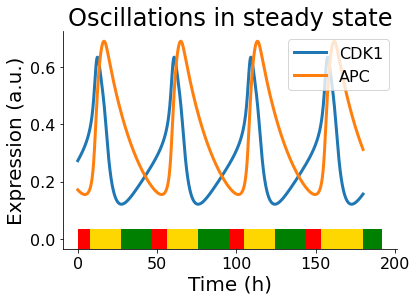

In [60]:
# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0[0:3600],out_phase0[0:3600,0],label='CDK1', linestyle = 'solid', linewidth = 3)
ax.plot(t_phase0[0:3600],out_phase0[0:3600,1],label='APC', linestyle = 'solid', linewidth = 3)
ax.hlines(y = 0, xmin = 0, xmax = new_minima[1], linestyle = 'solid', linewidth = 20, color = "red")
#ax.hlines(y = 0, xmin = new_minima[0], xmax = new_minima[1], linestyle = 'solid', linewidth = 20, color = "red")
ax.hlines(y = 0, xmin = new_minima[1], xmax = new_minima[2], linestyle = 'solid', linewidth = 20, color = "gold")
ax.hlines(y = 0, xmin = new_minima[2], xmax = new_minima[3], linestyle = 'solid', linewidth = 20, color = "green")
ax.hlines(y = 0, xmin = new_minima[3], xmax = new_minima[4], linestyle = 'solid', linewidth = 20, color = "red")
ax.hlines(y = 0, xmin = new_minima[4], xmax = new_minima[5], linestyle = 'solid', linewidth = 20, color = "gold")
ax.hlines(y = 0, xmin = new_minima[5], xmax = new_minima[6], linestyle = 'solid', linewidth = 20, color = "green")
ax.hlines(y = 0, xmin = new_minima[6], xmax = new_minima[7], linestyle = 'solid', linewidth = 20, color = "red")
ax.hlines(y = 0, xmin = new_minima[7], xmax = new_minima[8], linestyle = 'solid', linewidth = 20, color = "gold")
ax.hlines(y = 0, xmin = new_minima[8], xmax = new_minima[9], linestyle = 'solid', linewidth = 20, color = "green")
ax.hlines(y = 0, xmin = new_minima[9], xmax = new_minima[10], linestyle = 'solid', linewidth = 20, color = "red")
ax.hlines(y = 0, xmin = new_minima[10], xmax = new_minima[11], linestyle = 'solid', linewidth = 20, color = "gold")
ax.hlines(y = 0, xmin = new_minima[11], xmax = t_phase0[3600], linestyle = 'solid', linewidth = 20, color = "green")


ax.legend()
ax.set_title('Oscillations in steady state', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('Expression (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='upper right', prop={'size': 16}) #, bbox_to_anchor=(1, 0.5)
#plt.savefig('Figures/MN10/Fig3B_Simulations_steady_state_oscillations.pdf', bbox_inches='tight')


In [61]:
x_minima_CDK1 = argrelextrema(out_phase0[::,0], np.less)[0]
y_minima_CDK1 = out_phase0[x_minima_CDK1,0]

# for local maxima
x_minima_APC = argrelextrema(out_phase0[::,1], np.less)[0]
y_minima_APC = out_phase0[x_minima_APC,1]

print("Minima CDK1 are: ")
print(", ".join(map(str,x_minima_CDK1)))
print("Minima APC are: ")
print(", ".join(map(str,x_minima_APC)))

print("Minima CDK1 are: ")
print(", ".join(map(str,y_minima_CDK1)))
print("Minima APC are: ")
print(", ".join(map(str,y_minima_APC)))

minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
if x_minima_CDK1[0] > x_minima_APC[0]:
    minima[::2] = x_minima_APC
    minima[1::2] = x_minima_CDK1
else:
    minima[::2] = x_minima_CDK1 
    minima[1::2] = x_minima_APC    
minima = np.array(minima)/(timepoints_phase0/timespan_phase0)

minima
print(minima)

# Calculate difference between phases
phase_lengths = np.array([x - minima[i - 1] for i, x in enumerate(minima)][1:])

phase_lengths

Minima CDK1 are: 
550, 1518, 2486, 3454
Minima APC are: 
90, 1058, 2026, 2994, 3962
Minima CDK1 are: 
0.12116667804356893, 0.12116644915393482, 0.12116630290175603, 0.1211662447544536
Minima APC are: 
0.15500894339895452, 0.15500871061449936, 0.15500874331113906, 0.15500882263112167, 0.1550090448919833
[  4.5  27.5  52.9  75.9 101.3 124.3 149.7 172.7 198.1]


array([23. , 25.4, 23. , 25.4, 23. , 25.4, 23. , 25.4])

Do knock down 'experiments'

In [62]:
# PART 3.A: simulations to see whether the KD experiments are correctly reproduced. 
# Complete Knock-out

# Models
def KD_GREB1(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = 0 #s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


def KD_PR(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = 0 # s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


def KD_TFF1(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = 0 # s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


def KD_ER(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = 0 #s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]



In [63]:
# Initial conditions
z_mock = [CDK1_init, APC_init, CONC6_init, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]
z_greb1 = [CDK1_init, APC_init, CONC6_init, ER_init, Ce2er_init, PR_init, Ce2erpr_init, 0, Ce2erprgreb1_init, TFF1_init]
z_pr = [CDK1_init, APC_init, CONC6_init, ER_init, Ce2er_init, 0, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]
z_tff1 = [CDK1_init, APC_init, CONC6_init, ER_init, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, 0]
z_ER = [CDK1_init, APC_init, CONC6_init, 0, Ce2er_init, PR_init, Ce2erpr_init, GREB1_init, Ce2erprgreb1_init, TFF1_init]

t_kd = np.linspace(1, 24, 24)

mock = odeint(CellCycle_default,z_mock,t_kd)
kd_greb1 = odeint(KD_GREB1,z_greb1,t_kd)
kd_pr = odeint(KD_PR,z_pr,t_kd)
kd_tff1 = odeint(KD_TFF1,z_tff1,t_kd)
kd_ER = odeint(KD_ER,z_ER,t_kd)


In [64]:
#Save the KD data for plotting

dkd = {'dose_nM': np.repeat(100,24*5*3), 
       'timeID': np.hstack(np.repeat([np.arange(1,25,1)],5*3, axis = 0)), 
       "condition": (["mock"]*24*3 + ["siGREB1"]*24*3 + ["siPR"]*24*3 + ["siTFF1"]*24*3 + ["siESR1"]*24*3),
       "StateVar": (["GREB1"]*24 + ["PR"]*24 + ["TFF1"]*24)*5,
       "GFP": np.hstack((mock[:,7] + mock[:,8], mock[:,5] + mock[:,6] + mock[:,8],mock[:,9],
                         kd_greb1[:,7] + kd_greb1[:,8], kd_greb1[:,5] + kd_greb1[:,6] + kd_greb1[:,8],kd_greb1[:,9],
                         kd_pr[:,7] + kd_pr[:,8], kd_pr[:,5] + kd_pr[:,6] + kd_pr[:,8],kd_pr[:,9],
                         kd_tff1[:,7] + kd_tff1[:,8], kd_tff1[:,5] + kd_tff1[:,6] + kd_tff1[:,8],kd_tff1[:,9],
                         kd_ER[:,7] + kd_ER[:,8], kd_ER[:,5] + kd_ER[:,6] + kd_ER[:,8],kd_ER[:,9]))}

simu_KDdata = pd.DataFrame(data = dkd)

simu_KDdata

#simu_KDdata.to_csv("M010_simu_KDdata.csv")



,dose_nM,timeID,condition,StateVar,GFP
0,100,1,mock,GREB1,0.913435
1,100,2,mock,GREB1,0.920984
2,100,3,mock,GREB1,0.992250
3,100,4,mock,GREB1,1.184374
4,100,5,mock,GREB1,1.514849
...,...,...,...,...,...
355,100,20,siESR1,TFF1,0.967190
356,100,21,siESR1,TFF1,0.967190
357,100,22,siESR1,TFF1,0.967190
358,100,23,siESR1,TFF1,0.967190


Text(0, 0.5, 'Proteins')

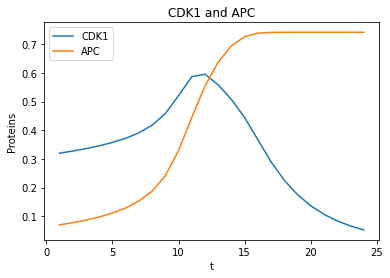

In [65]:
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_kd,kd_greb1[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_kd,kd_greb1[:,1],label='APC', linestyle = 'solid')

ax.legend()
ax.set_title('CDK1 and APC')
ax.set_xlabel('t')
ax.set_ylabel('Proteins')

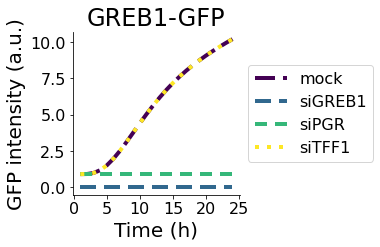

In [66]:
# Plot simulation results for GREB1 protein
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(t_kd, mock[:,7] + mock[:,8],label='mock', dashes = [5, 2], color = "#440154FF", linewidth = 4)
ax.plot(t_kd, kd_greb1[:,7] + kd_greb1[:,8],label='siGREB1', dashes = [4, 2], color = "#31688EFF", linewidth = 4)
ax.plot(t_kd, kd_pr[:,7] + kd_pr[:,8],label='siPGR', dashes = [3, 2], color = "#35B779FF", linewidth = 4)
ax.plot(t_kd, kd_tff1[:,7] + kd_tff1[:,8],label='siTFF1', dashes = [1, 2], color = "#FDE725FF", linewidth = 4)

ax.set_title('GREB1-GFP', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('GFP intensity (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.xaxis.set_ticks(np.arange(0, 26, 5))
#plt.savefig('Figures/MN10/Fig2F_GREB1_KDsimu.pdf', bbox_inches='tight')

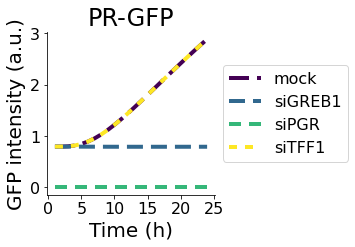

In [67]:
# Plot simulation results for PR protein
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(t_kd,mock[:,5] + mock[:,6] + mock[:,8],label='mock', dashes = [5, 2], color = "#440154FF", linewidth = 4)
ax.plot(t_kd,kd_greb1[:,5] + kd_greb1[:,6] + kd_greb1[:,8],label='siGREB1', dashes = [4, 2], color = "#31688EFF", linewidth = 4)
ax.plot(t_kd,kd_pr[:,5] + kd_pr[:,6] + kd_pr[:,8],label='siPGR', dashes = [3, 2], color = "#35B779FF", linewidth = 4)
ax.plot(t_kd,kd_tff1[:,5] + kd_tff1[:,6] + kd_tff1[:,8],label='siTFF1', dashes = [2, 2], color = "#FDE725FF", linewidth = 4)

ax.set_title('PR-GFP', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('GFP intensity (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.xaxis.set_ticks(np.arange(0, 26, 5))
#plt.savefig('Figures/MN10/Fig2F_PR_KDsimu.pdf', bbox_inches='tight')



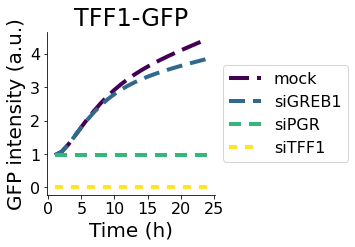

In [68]:
# Plot simulation results for TFF1 protein
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(t_kd,mock[:,9],label='mock', dashes = [5, 2], color = "#440154FF", linewidth = 4)
ax.plot(t_kd,kd_greb1[:,9],label='siGREB1', dashes = [4, 2], color = "#31688EFF", linewidth = 4)
ax.plot(t_kd,kd_pr[:,9],label='siPGR', dashes = [3, 2], color = "#35B779FF", linewidth = 4)
ax.plot(t_kd,kd_tff1[:,9],label='siTFF1', dashes = [2, 2], color = "#FDE725FF", linewidth = 4)
#ax.plot(t_kd,kd_ER[:,9],label='siESR', linestyle = 'solid')


ax.set_title('TFF1-GFP', fontsize=24)
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('GFP intensity (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 16})
ax.xaxis.set_ticks(np.arange(0, 26, 5))
#plt.savefig('Figures/MN10/Fig2F_TFF1_KDsimu.pdf', bbox_inches='tight')


Text(0, 0.5, 'Proteins')

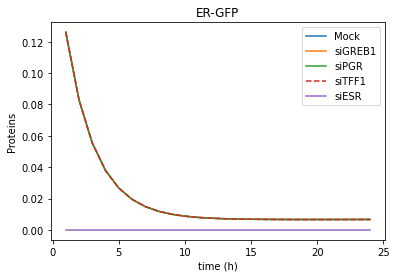

In [69]:
# Plot simulation results for ER protein
fig,ax = plt.subplots()
ax.plot(t_kd,mock[:,3],label='Mock', linestyle = 'solid')
ax.plot(t_kd,kd_greb1[:,3],label='siGREB1', linestyle = 'solid')
ax.plot(t_kd,kd_pr[:,3],label='siPGR', linestyle = 'solid')
ax.plot(t_kd,kd_tff1[:,3],label='siTFF1', linestyle = 'dashed')
ax.plot(t_kd,kd_ER[:,3],label='siESR', linestyle = 'solid')


ax.legend()
ax.set_title('ER-GFP')
ax.set_xlabel('time (h)')
ax.set_ylabel('Proteins')

### Simulations of experiment. 100 cells randomly drawn in time interval of one complete cell cycle.
Phase one: sustained oscillations with little, but constant E2.

Phase two: siRNA transfection, i.e. knock downs, if applicable. Otherwise same as phase 1, sustained oscillations in culture medium

Phase three: starvation, in absence of E2

Phase four: exposure to E2

### Phase one: sustained oscillations with little, but constant E2.

Text(0, 0.5, 'Proteins')

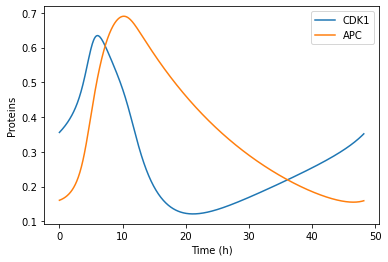

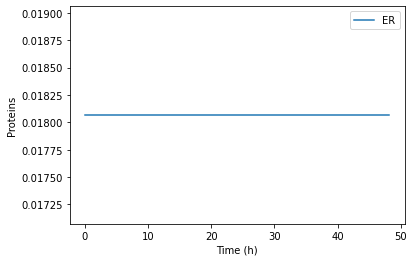

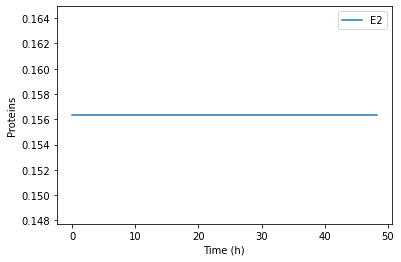

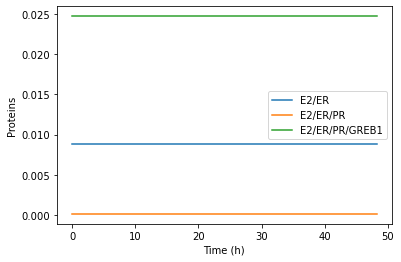

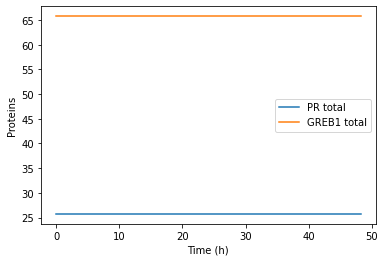

In [70]:
# Phase one: sustained oscillations with little (EC_t_min24 * 1.5), but constant E2.

# Model
def CellCycle_phase1(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1,  Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * r * APC * Ce2erprgreb1 * PR
    
    # E2 signaling
    dE2 = 0 # - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR  / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


# Initial conditions
z_phase1 = out_phase0[out_phase0.shape[0]-1,::]

# Make time range
timespan_phase1 = period_part2
timepoints_phase1 = 1000

# Phase 1 time span 
t_phase1 = np.linspace(0, timespan_phase1, timepoints_phase1)

# Run simulation
out_phase1 = odeint(CellCycle_phase1, z_phase1, t_phase1)

# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_phase1[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_phase1,out_phase1[:,1],label='APC', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_phase1[:,3],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_phase1[:,2],label='E2', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_phase1[:,4],label='E2/ER', linestyle = 'solid')
ax.plot(t_phase1,out_phase1[:,6],label='E2/ER/PR', linestyle = 'solid')
ax.plot(t_phase1,out_phase1[:,8],label='E2/ER/PR/GREB1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# # Plot simulation results
# fig,ax = plt.subplots()
# ax.plot(t_phase1, out_phase1[:,7], label='GREB1', linestyle = 'solid') 
# ax.legend()
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Proteins')

# # Plot simulation results
# fig,ax = plt.subplots()
# ax.plot(t_phase1,out_phase1[:,5], label='PR', linestyle = 'solid') 
# ax.legend()
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_phase1[:,5] + out_phase1[:,6] + out_phase1[:,8], label='PR total', linestyle = 'solid') 
ax.plot(t_phase1,out_phase1[:,7] + out_phase1[:,8], label='GREB1 total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# # Plot simulation results
# fig,ax = plt.subplots()
# ax.plot(t_phase1,out_phase1[:,9],label='TFF1', linestyle = 'solid')
# ax.legend()
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Proteins')

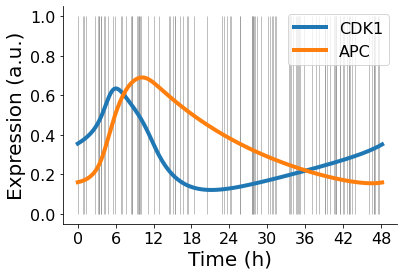

In [71]:
# Set seed for reproducability
random.seed(2023)

# Sample 100 cells in these 50 hours of one cell cycle
nsimus = 100

sample = random.choices(range(0,timepoints_phase1), k = nsimus)
sample_time = t_phase1[sample]
sample_cdk1 = out_phase1[sample,0]
sample_apc = out_phase1[sample,1]


# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase1,out_phase1[:,0],label='CDK1', linestyle = 'solid', linewidth = 4)
ax.plot(t_phase1,out_phase1[:,1],label='APC', linestyle = 'solid', linewidth = 4)
ax.vlines(sample_time, ymin = 0, ymax = 1, color = "grey", lw = 0.5)
#ax.scatter(sample_time, sample_cdk1,label='CDK1', marker = 'o')
#ax.scatter(sample_time, sample_apc,label='APC', marker = 'o')

ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('Expression (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.set_ticks(np.arange(0, 49, 6))
ax.legend(loc='upper right', prop={'size': 16}) #, bbox_to_anchor=(1, 0.5)
#plt.savefig('Figures/MN10/Fig3F_Simulations_steady_state_oscillations.pdf', bbox_inches='tight')



### Phase two: siRNA transfection, i.e. knock downs, if applicable. Otherwise plating in complete medium.

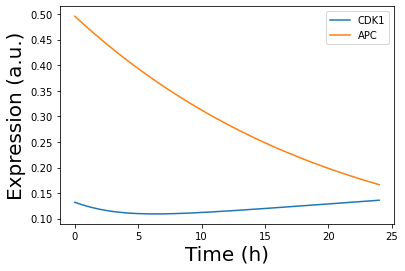

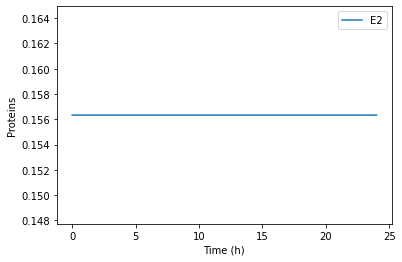

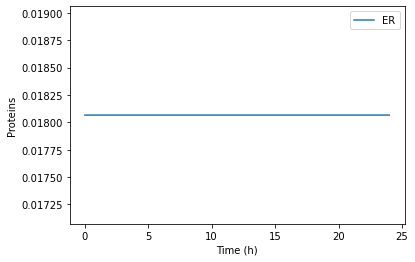

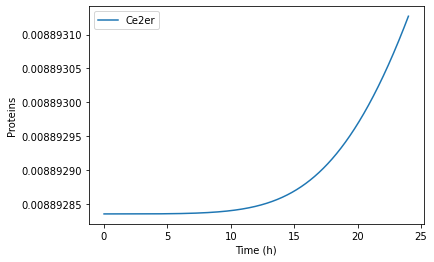

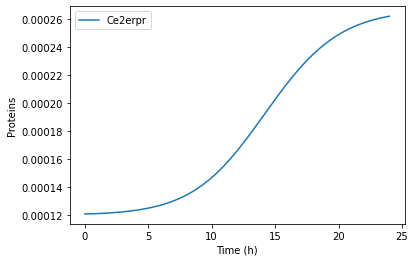

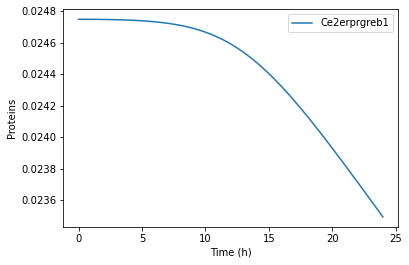

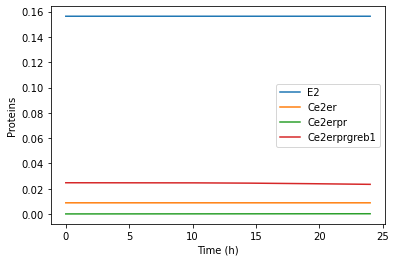

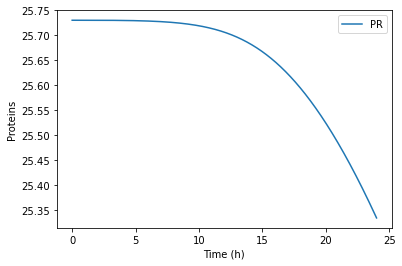

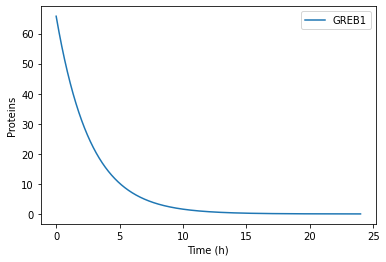

In [72]:
# Phase two: siRNA transfection, i.e. knock downs, if applicable

treatment = "GREB1 KD" # choose from "Mock", "GREB1 KD" or "PR KD"
concentration = CONC6_init # Choose from 0, CONC4_init and CONC6_init

if treatment == "Mock":
    GREB1_KD = False # False # True
    ER_KD = False
    PR_KD = False # False # True
elif treatment == "GREB1 KD":
    GREB1_KD = True # False # True
    ER_KD = False
    PR_KD = False # False # True
elif treatment == "PR KD":
    GREB1_KD = False # False # True
    ER_KD = False
    PR_KD = True # False # True
else:
    print("ERROR!! Not a valid treatment. Choose from \"Mock\", \"GREB1 KD\" or \"PR KD\"")

# Model
def CellCycle_phase2(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1, Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * APC * r * Ce2erprgreb1 * PR
    
    dE2 = 0
    if not ER_KD:
        dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    else:
        dER = - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    if not PR_KD:
        dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR
    else: 
        dPR = - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    if not GREB1_KD:
        dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    elif GREB1_KD:
        dGREB1 = - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


if treatment == "GREB1 KD" or treatment == "PR KD":
    
    # Make time range
    timespan_phase2 = 24
    timepoints_phase2 = 10000

    simus_phase2 = np.empty((nsimus,timepoints_phase2,out_phase1.shape[1]))

    for i in range(0,nsimus):

        # Initial conditions
        z_phase2 = np.hstack((sample_cdk1[i],sample_apc[i],out_phase1[sample[i],2::])) 

        # Phase 1 time span 
        t_phase2 = np.linspace(0, timespan_phase2, timepoints_phase2)

        # Run simulation
        out_phase2 = odeint(CellCycle_phase2, z_phase2, t_phase2)

        # Bind simulations
        simus_phase2[i] = out_phase2


    # Phase 2 plotting
    # Plot simulation results
    fig,ax = plt.subplots()
    # ax.plot(t_phase2,out_phase2[:,0],label='CDK1', linestyle = 'solid')
    # ax.plot(t_phase2,out_phase2[:,1],label='APC', linestyle = 'solid')
    ax.plot(t_phase2,simus_phase2[0][:,0],label='CDK1', linestyle = 'solid')
    ax.plot(t_phase2,simus_phase2[0][:,1],label='APC', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)', fontsize=20)
    ax.set_ylabel('Expression (a.u.)', fontsize=20)

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,2],label='E2', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,3],label='ER', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,4],label='Ce2er', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,6],label='Ce2erpr', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,8],label='Ce2erprgreb1', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,2],label='E2', linestyle = 'solid')
    ax.plot(t_phase2,out_phase2[:,4],label='Ce2er', linestyle = 'solid')
    ax.plot(t_phase2,out_phase2[:,6],label='Ce2erpr', linestyle = 'solid')
    ax.plot(t_phase2,out_phase2[:,8],label='Ce2erprgreb1', linestyle = 'solid')
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2,out_phase2[:,5] + out_phase2[:,6] + out_phase2[:,8], label='PR', linestyle = 'solid') 
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')

    # Plot simulation results
    fig,ax = plt.subplots()
    ax.plot(t_phase2, out_phase2[:,7] + out_phase2[:,8], label='GREB1', linestyle = 'solid') 
    ax.legend()
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Proteins')


### Phase three: starvation, in absence of E2

Text(0, 0.5, 'Proteins')

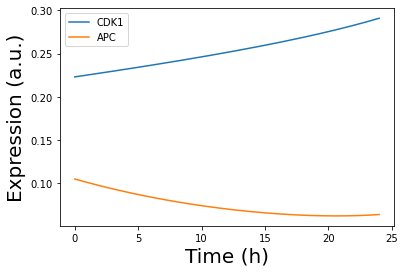

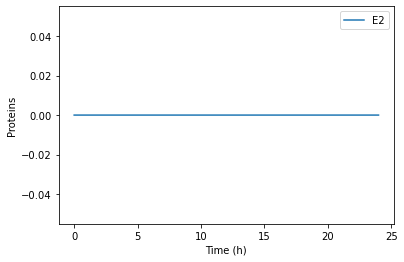

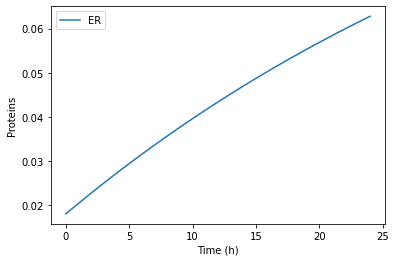

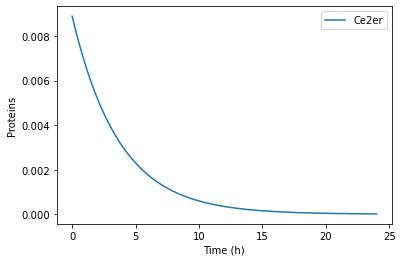

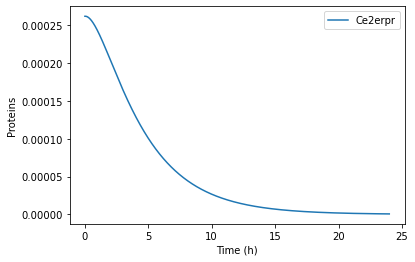

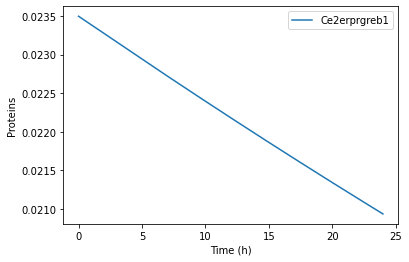

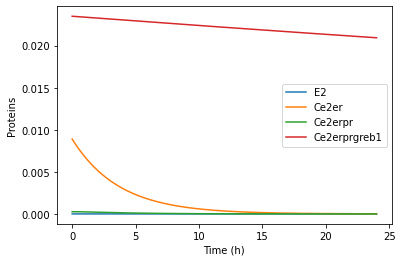

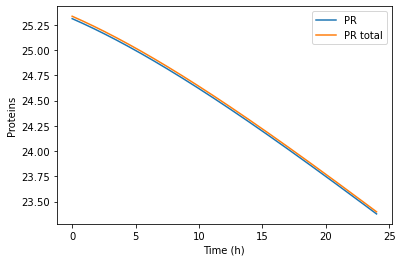

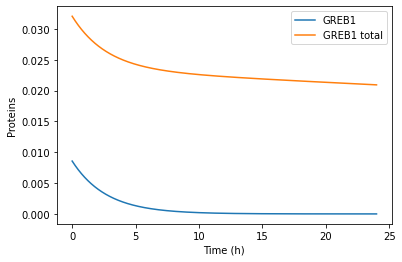

In [73]:
# Phase three: starvation, in absence of E2

# Model
def CellCycle_phase3(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1, Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * APC * r * Ce2erprgreb1 * PR
    
    dE2 = 0
    if not ER_KD:
        dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    else:
        dER = - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    if not PR_KD:
        dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR
    else: 
        dPR = - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    if not GREB1_KD:
        dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    elif GREB1_KD:
        dGREB1 = - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


# Make time range
timespan_phase3 = 24
timepoints_phase3 = 10000


if treatment == "Mock":
    simus_phase3 = np.empty((nsimus,timepoints_phase3,out_phase1.shape[1]))
else:
    simus_phase3 = np.empty((nsimus,timepoints_phase3,out_phase2.shape[1]))

for i in range(0,nsimus):
    
    if treatment == "Mock":
        # Initial conditions
        z_phase3 = np.hstack((sample_cdk1[i],sample_apc[i], 0,out_phase1[sample[i],3::])) 
    elif treatment == "GREB1 KD" or treatment == "PR KD":
        # Initial conditions
        z_phase3 = np.hstack((simus_phase2[i,simus_phase2.shape[1]-1,0:2], 0, simus_phase2[i,simus_phase2.shape[1]-1,3::]))

    # Phase 3 time span 
    t_phase3 = np.linspace(0, timespan_phase3, timepoints_phase3)

    # Run simulation
    out_phase3 = odeint(CellCycle_phase3, z_phase3, t_phase3)
    
    # Bind simulations
    simus_phase3[i] = out_phase3

# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,1],label='APC', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('Expression (a.u.)', fontsize=20)

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,2],label='E2', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,3],label='ER', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,4],label='Ce2er', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,6],label='Ce2erpr', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,8],label='Ce2erprgreb1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,2],label='E2', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,4],label='Ce2er', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,6],label='Ce2erpr', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,8],label='Ce2erprgreb1', linestyle = 'solid')
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,5], label='PR', linestyle = 'solid') 
ax.plot(t_phase3,out_phase3[:,5] + out_phase3[:,6] + out_phase3[:,8], label='PR total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3, out_phase3[:,7], label='GREB1', linestyle = 'solid') 
ax.plot(t_phase3, out_phase3[:,7] + out_phase3[:,8], label='GREB1 total', linestyle = 'solid') 
ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



### Phase 4: exposure to E2

<ipython-input-74-274349a5d430>:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2,ax2 = plt.subplots()


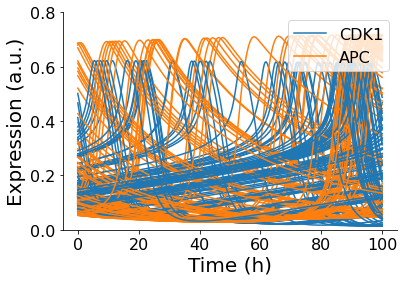

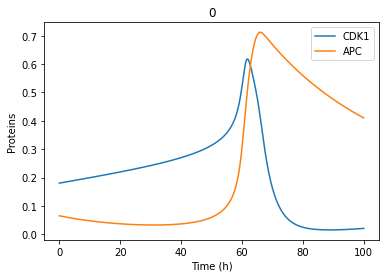

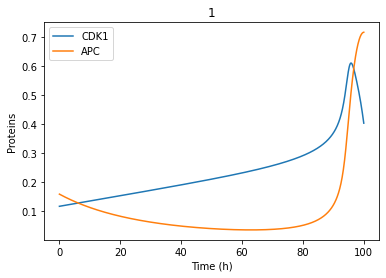

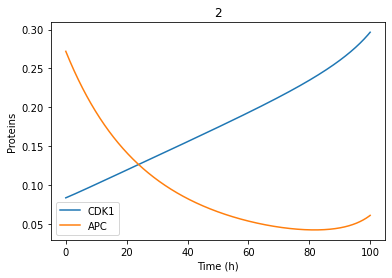

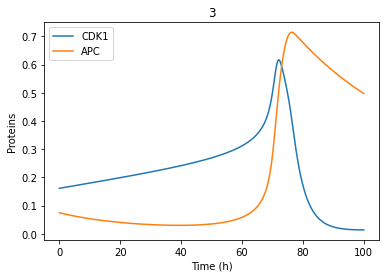

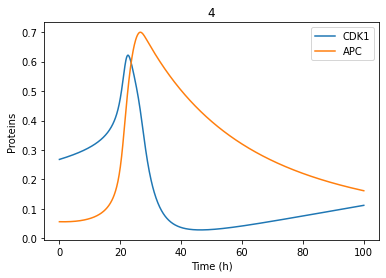

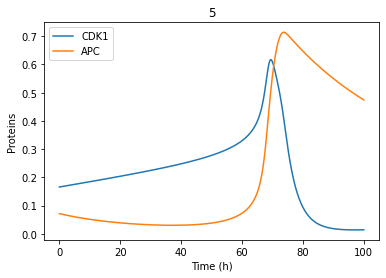

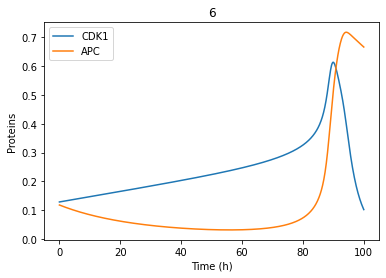

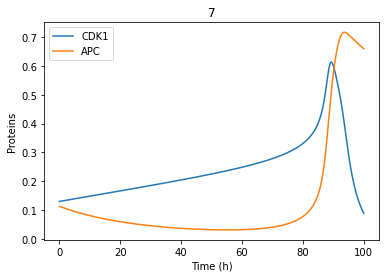

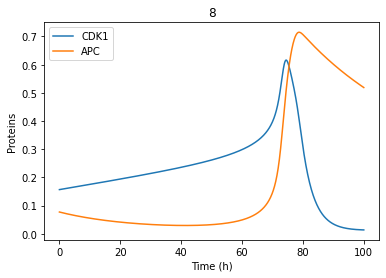

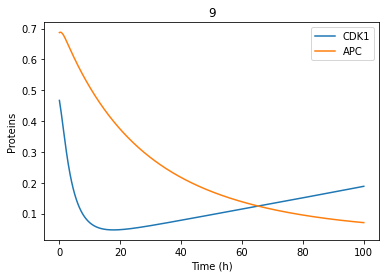

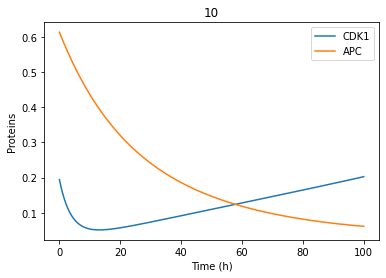

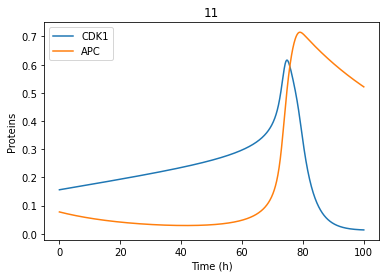

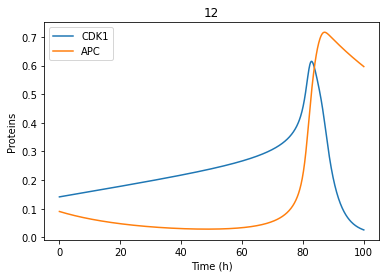

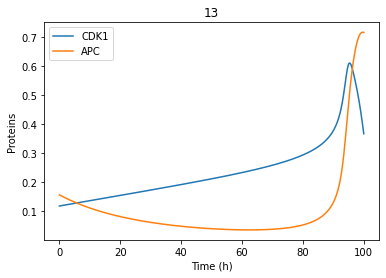

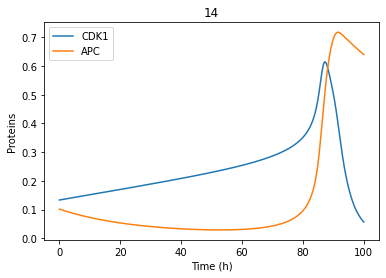

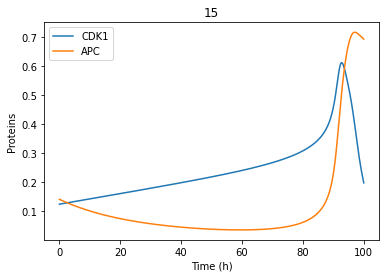

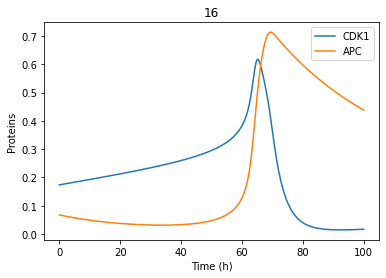

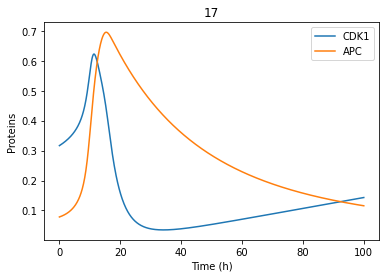

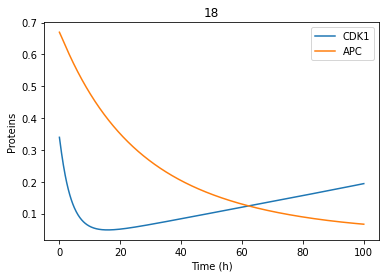

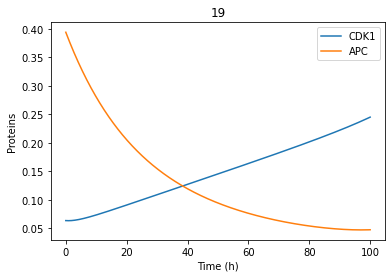

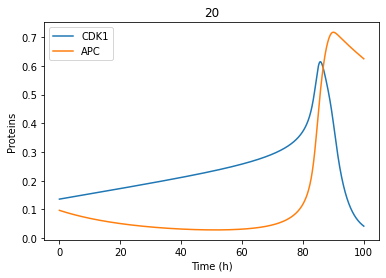

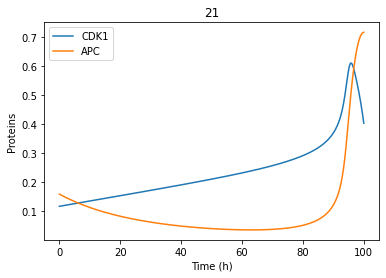

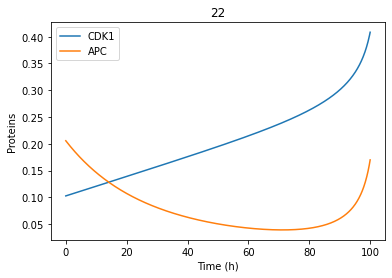

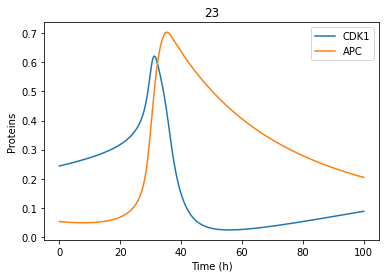

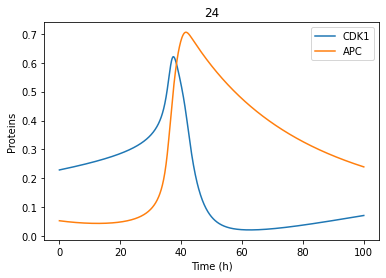

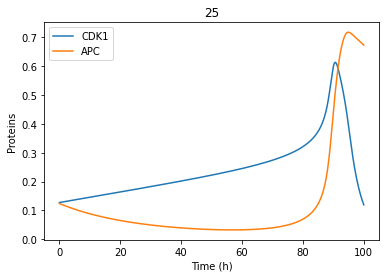

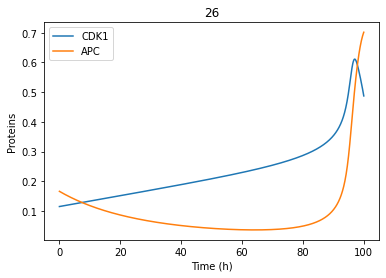

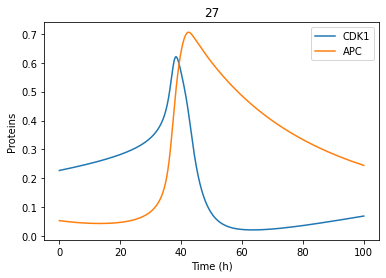

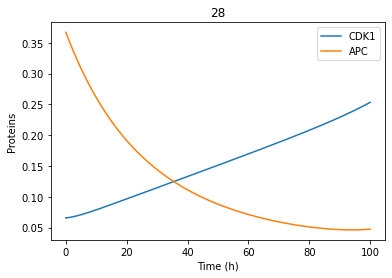

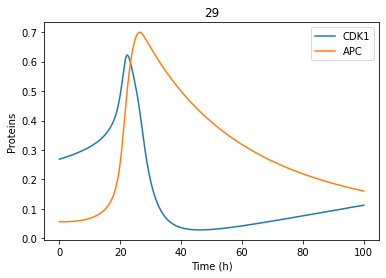

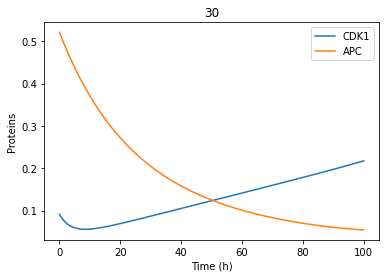

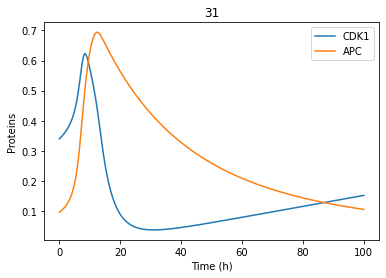

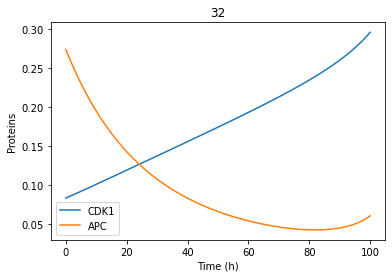

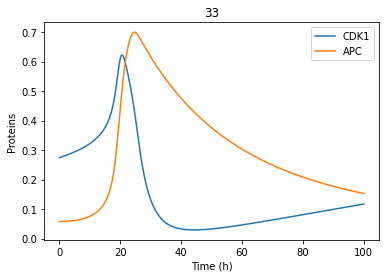

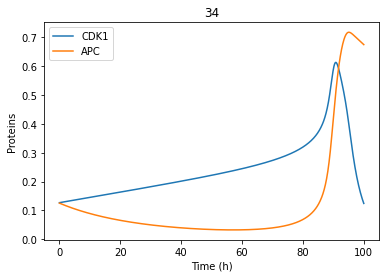

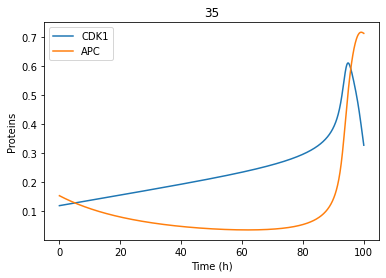

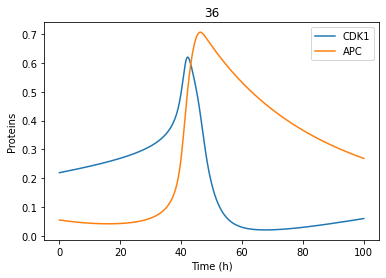

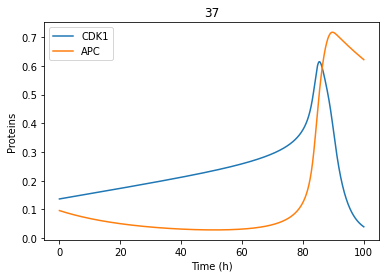

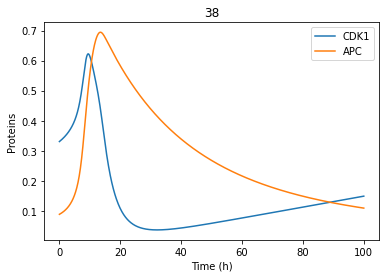

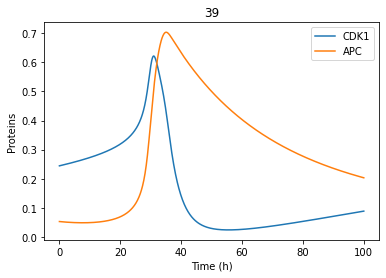

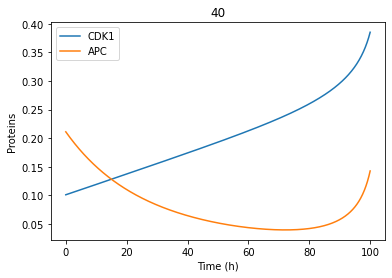

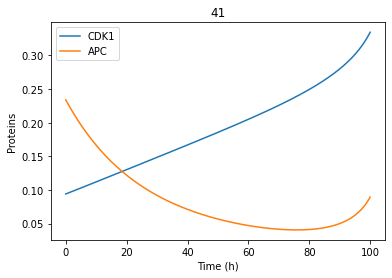

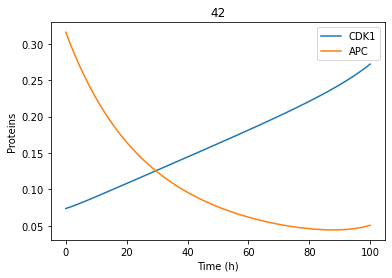

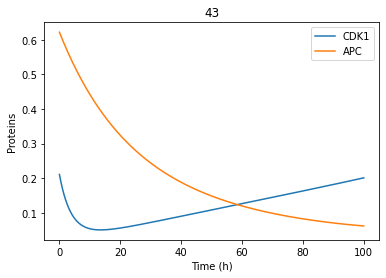

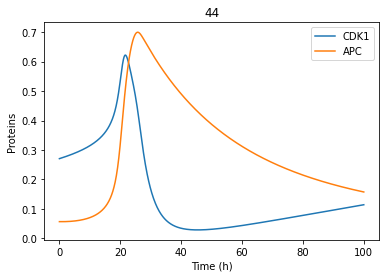

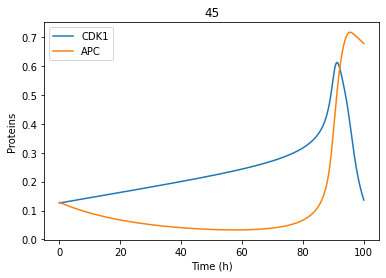

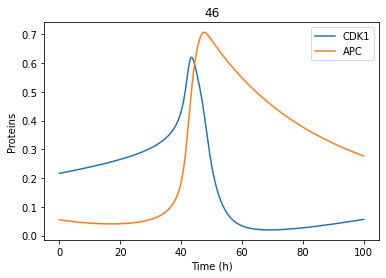

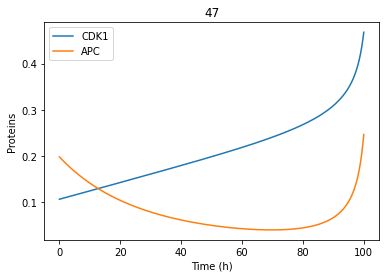

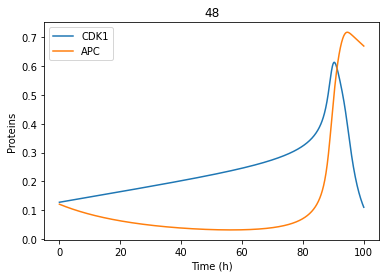

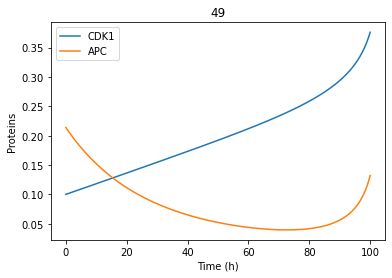

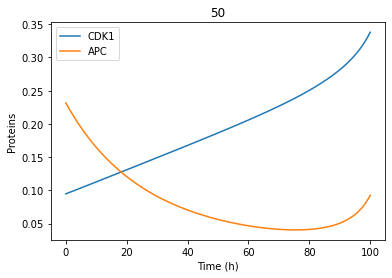

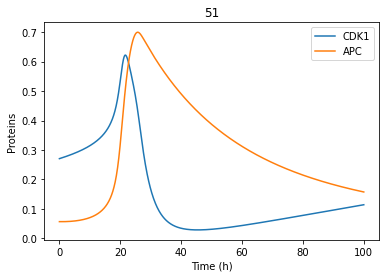

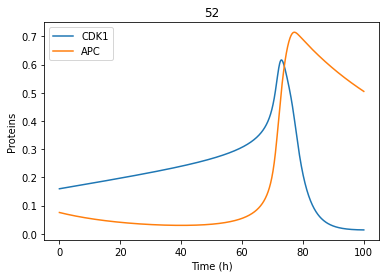

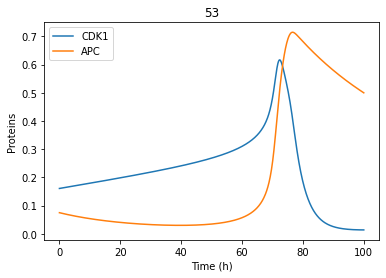

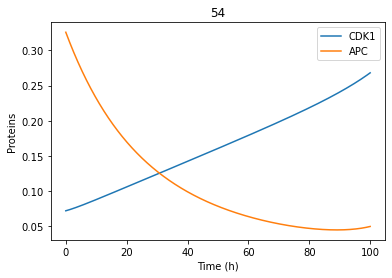

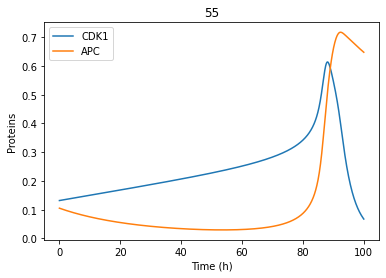

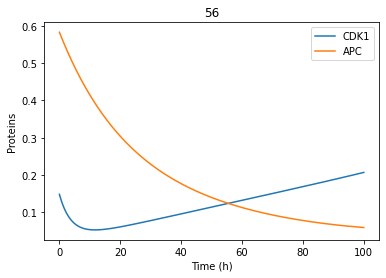

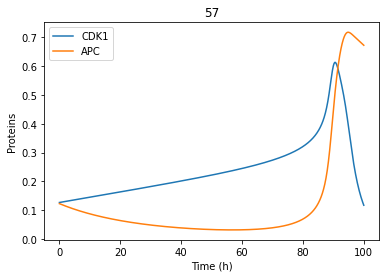

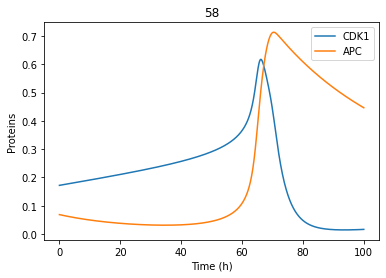

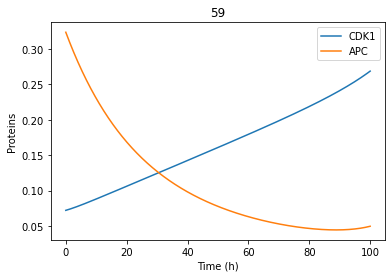

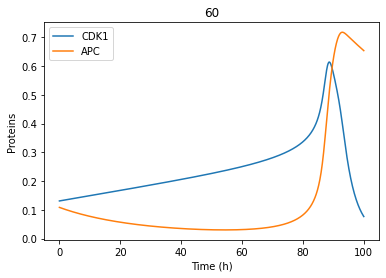

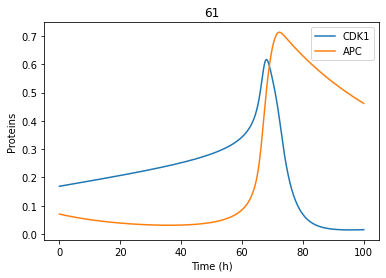

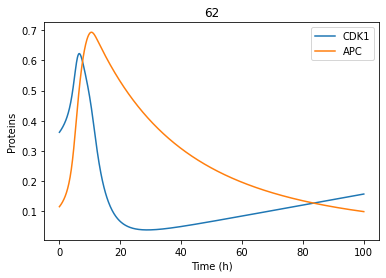

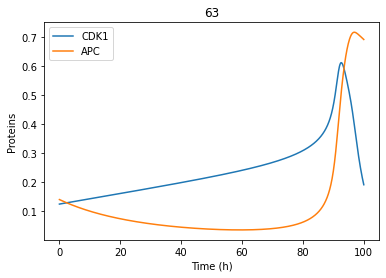

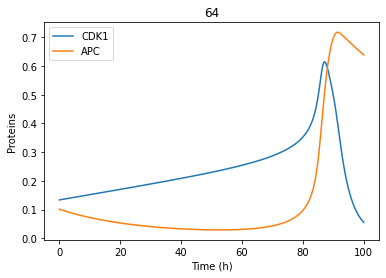

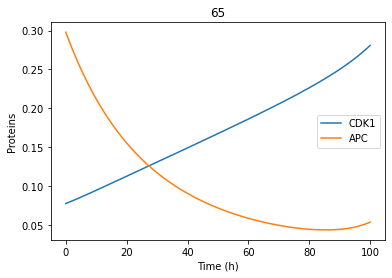

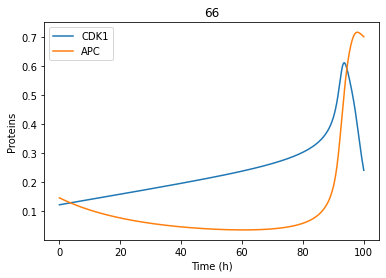

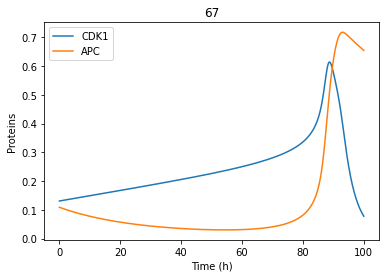

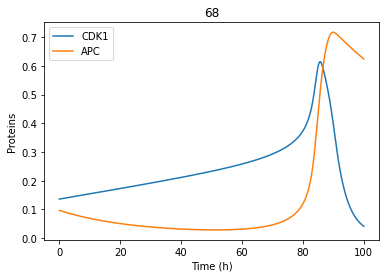

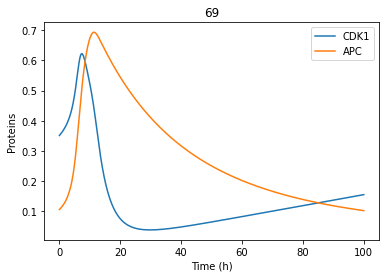

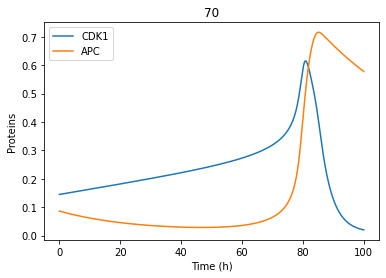

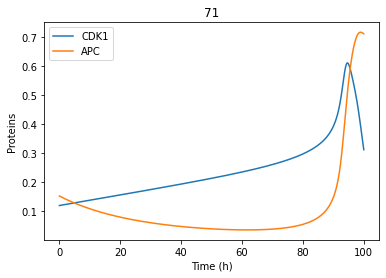

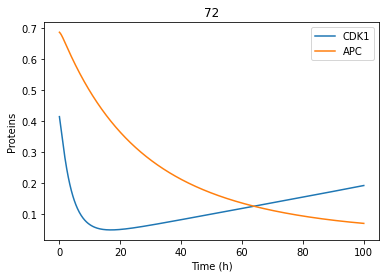

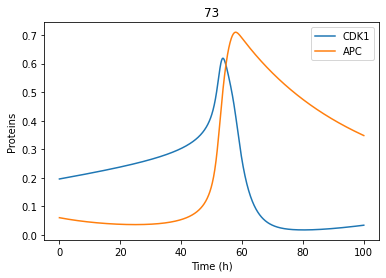

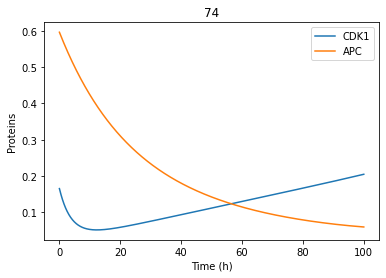

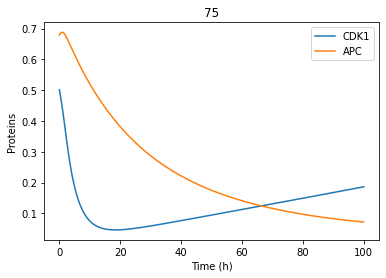

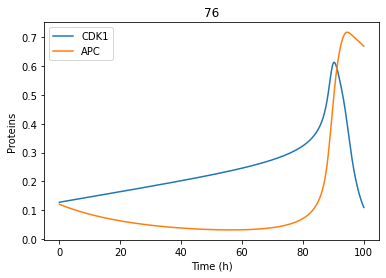

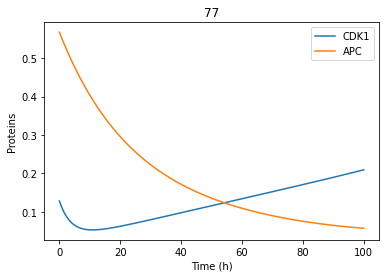

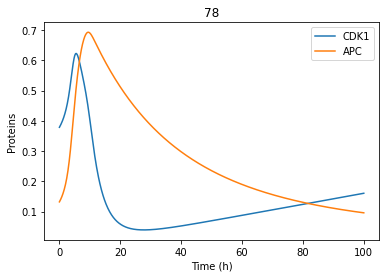

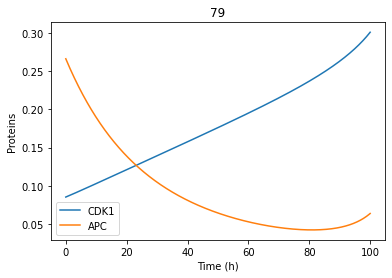

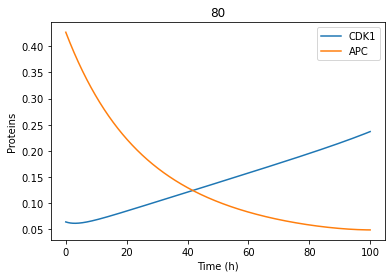

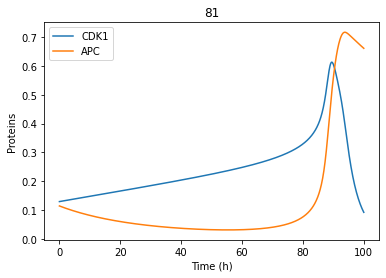

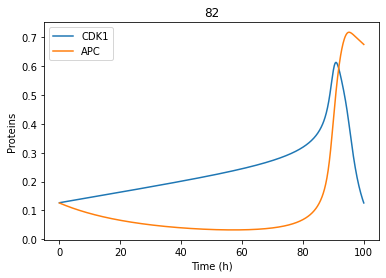

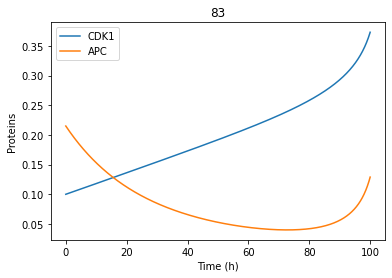

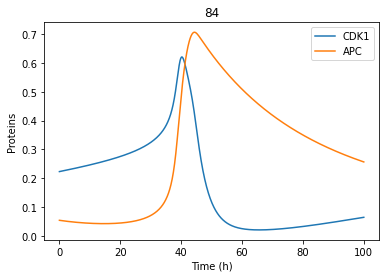

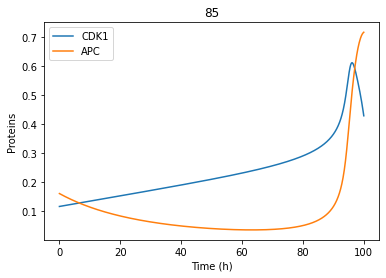

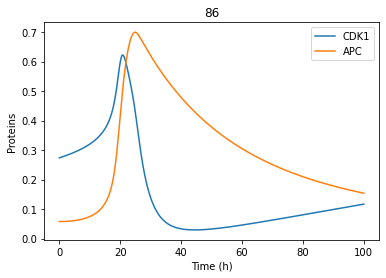

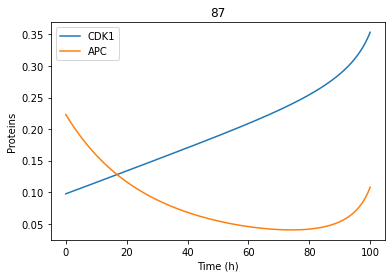

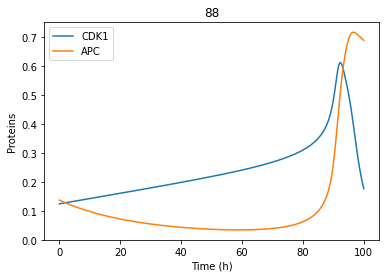

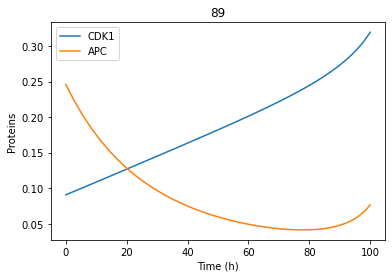

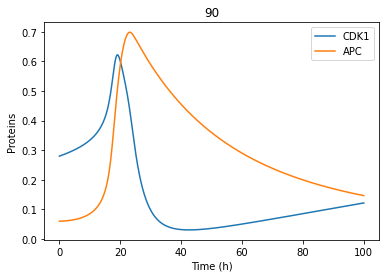

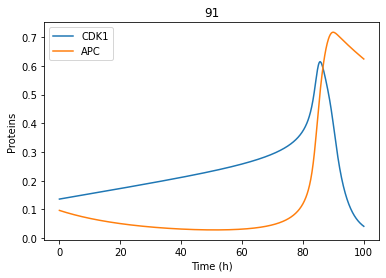

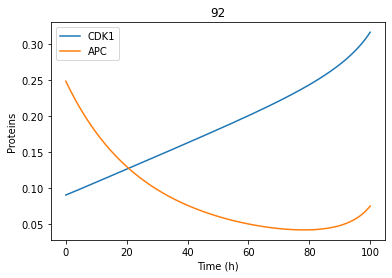

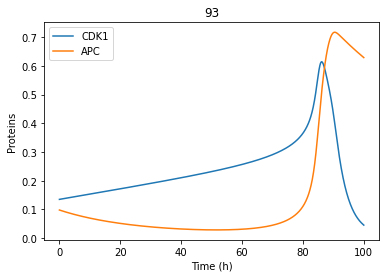

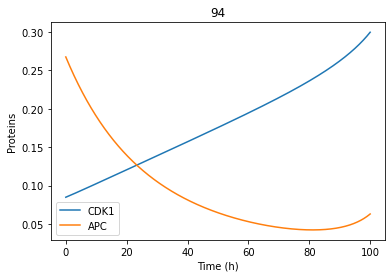

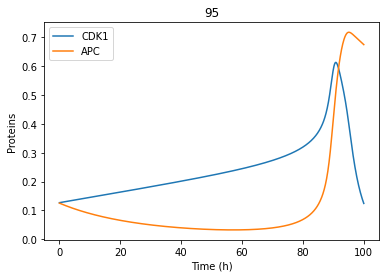

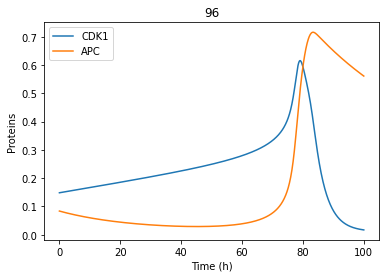

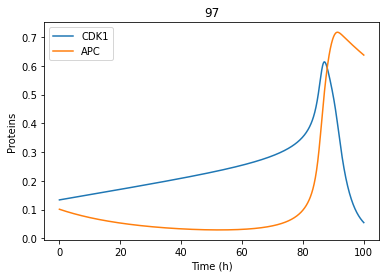

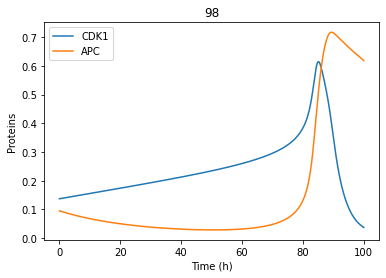

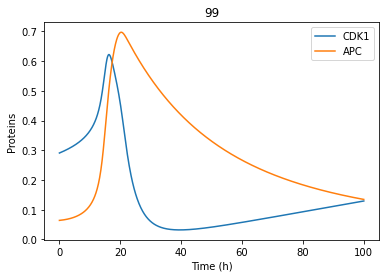

In [74]:
# Phase 4: exposure to E2

# Model
def CellCycle_phase4(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1, Ce2erprgreb1, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * APC * r * Ce2erprgreb1 * PR
    
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    if not ER_KD:
        dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    else:
        dER = - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    if not PR_KD:
        dPR = s_pr + stim_pr * Ce2erprgreb1 / (1 + Ce2erprgreb1) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR
    else: 
        dPR = - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    if not GREB1_KD:
        dGREB1 = s_greb1 - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) + stim_greb1 * Ce2erprgreb1 / (1 + Ce2erprgreb1) - d_greb1 * GREB1
    elif GREB1_KD:
        dGREB1 = - b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_greb1 * GREB1
    dCe2erprgreb1 = b_e2erprgreb1 * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprgreb1 * Ce2erprgreb1
    
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprgreb1, dTFF1]


# Make time range
timespan_phase4 = 100
timepoints_phase4 = 1000

simus_phase4 = np.empty((nsimus,timepoints_phase4,out_phase3.shape[1]))

# Phase 4 plotting
# Plot simulation results

fig1,ax1 = plt.subplots()

for i in range(0,nsimus):
    # Initial conditions
    z_phase4 = np.hstack((simus_phase3[i,simus_phase3.shape[1]-1,0:2], concentration, simus_phase3[i,simus_phase3.shape[1]-1,3::]))

    # Phase 1 time span 
    t_phase4 = np.linspace(0, timespan_phase4, timepoints_phase4)

    # Run simulation
    out_phase4 = odeint(CellCycle_phase4, z_phase4, t_phase4)

    # Bind simulations
    simus_phase4[i] = out_phase4

    # Make combined plot
    ax1.plot(t_phase4, out_phase4[:,0],label='CDK1', linestyle = 'solid', color = 'C0')
    ax1.plot(t_phase4, out_phase4[:,1],label='APC', linestyle = 'solid', color = 'C1')
    ax1.set_xlabel('Time (h)', fontsize=20)

    # Make separate plots
    fig2,ax2 = plt.subplots()
    ax2.plot(t_phase4, out_phase4[:,0],label='CDK1', linestyle = 'solid', color = 'C0')
    ax2.plot(t_phase4, out_phase4[:,1],label='APC', linestyle = 'solid', color = 'C1')

    ax2.set_title(str(i))
    ax2.set_xlabel('Time (h)')
    ax2.set_ylabel('Proteins')

    line_apc = Line2D([0], [0], label='APC', color='C1')
    line_cdk1 = Line2D([0], [0], label='CDK1', color='C0')

    ax2.legend(handles = [line_cdk1,line_apc])

# Make combined plot
line_apc = Line2D([0], [0], label='APC', color='C1')
line_cdk1 = Line2D([0], [0], label='CDK1', color='C0')

ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Expression (a.u.)', fontsize=20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylim(0,0.8)
ax1.legend(handles = [line_cdk1,line_apc], 
           loc='upper right', prop={'size': 16}) #, bbox_to_anchor=(1, 0.5)

# if treatment == "Mock" and concentration == 0:
#     ax1.set_title('Control', fontsize=24)
#     fig1.savefig('Figures/MN10/Fig3G_All_simulations_CDK1_APC_Mock_control.pdf', bbox_inches='tight')
# elif treatment == "Mock" and concentration == CONC4_init:
#     ax1.set_title('1 nM E2', fontsize=24)
#     fig1.savefig('Figures/MN10/Fig3H_All_simulations_CDK1_APC_Mock_conc4.pdf', bbox_inches='tight')
# elif treatment == "Mock" and concentration == CONC6_init:
#     ax1.set_title('100 nM E2', fontsize=24)
#     fig1.savefig('Figures/MN10/Fig3H_All_simulations_CDK1_APC_Mock_conc6.pdf', bbox_inches='tight')
# elif treatment == "GREB1 KD" and concentration == CONC6_init:
#     ax1.set_title('GREB1 knockdown', fontsize=24)
#     fig1.savefig('Figures/MN10/Fig5C_All_simulations_CDK1_APC_GREB1_KD_conc6.pdf', bbox_inches='tight')
# elif treatment == "PR KD" and concentration == CONC6_init:
#     ax1.set_title('PR knockdown', fontsize=24)
#     fig1.savefig('Figures/MN10/Fig5D_All_simulations_CDK1_APC_PR_KD_conc6.pdf', bbox_inches='tight')


In [75]:
phase_length_list = []

for i in range(0,nsimus):
    print("\n")
    print(i)
    
    simulation = simus_phase4[i]

    # for local minima

    x_minima_CDK1 = argrelextrema(simulation[::,0], np.less)[0]
    y_minima_CDK1 = simulation[x_minima_CDK1,0]

    x_minima_APC = argrelextrema(simulation[::,1], np.less)[0]
    y_minima_APC = simulation[x_minima_APC,1]

    # for local maxima

    x_maxima_CDK1 = argrelextrema(simulation[::,0], np.greater)[0]
    y_maxima_CDK1 = simulation[x_maxima_CDK1,0]

    x_maxima_APC = argrelextrema(simulation[::,1], np.greater)[0]
    y_maxima_APC = simulation[x_maxima_APC,1]

    print("Minima CDK1 are: ")
    print(", ".join(map(str,x_minima_CDK1)))
    print("Minima APC are: ")
    print(", ".join(map(str,x_minima_APC)))
    
    print("Maxima CDK1 are: ")
    print(", ".join(map(str,x_maxima_CDK1)))
    print("Maxima APC are: ")
    print(", ".join(map(str,x_maxima_APC)))
    
#     # Check whether there is an APC maximum. If not, phase lengths cannot be determined.
#     if len(x_maxima_APC) == 0: 
#         print("APC maximum is missing. Not enough data to determine phase lengths.")
#         phase_lengths = []

    # Check whether there are sufficient maxima and minima. If not, phase lengths cannot be determined.
    if len(x_maxima_APC) == 0 or len(x_minima_CDK1) == 0 or len(x_minima_APC) == 0:
        print("Not enough data to determine phase lengths")
        phase_lengths = []
        
    else:

        # Get the first APC minimum
        first_APC_minimum = y_minima_APC[0]

        # Get the first APC maximum, but if APC starts with a maximum, then take the second maximum 
        # Unless the second maximum does not exist, then take the first maximum
        if x_maxima_APC[0] < x_minima_APC[0] and len(y_maxima_APC) > 1:
            first_APC_maximum = y_maxima_APC[1]
        else:
            first_APC_maximum = y_maxima_APC[0]

        # Calculate the difference between the maximum and minimum
        difference = first_APC_maximum - first_APC_minimum
        print("This is the difference between the first APC maximum and minimum:")
        print(difference)

        # Get threshold for G1S transition
        G1S_thresholds = y_minima_APC + difference * 0.05
        G1S_threshold = G1S_thresholds[0]
        print("G1/S threshold of first minimum:")
        print(G1S_threshold)

        # Get timepoints when APC goes beneath the threshold and increases above it again
        previous = simulation[0,1] < G1S_threshold
        indices_G1S = []
        for j, x in enumerate(simulation[1::,1] < G1S_threshold):
            current = x
            # If there is a switch from False to True, get the index for True
            if current and not previous:
                index = j+1
                indices_G1S.append(index/(timepoints_phase4/timespan_phase4))
            elif not current and previous:
                index = j
                indices_G1S.append(index/(timepoints_phase4/timespan_phase4))

            previous = current

        print("Indices for G1/S start and end:")
        print(indices_G1S)

        # Merge minima into one array
        if len(x_minima_CDK1) > 1 and len(x_minima_CDK1) == len(x_minima_APC):
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
            if x_minima_CDK1[0] < x_minima_APC[0]:
                minima[::2] = x_minima_CDK1
                minima[1::2] = x_minima_APC
            else:
                minima[::2] = x_minima_APC
                minima[1::2] = x_minima_CDK1

            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        elif len(x_minima_CDK1) < len(x_minima_APC) and x_minima_APC[0] < x_minima_CDK1[0]:
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
            minima[::2] = x_minima_APC
            minima[1::2] = x_minima_CDK1
            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        elif len(x_minima_CDK1) < len(x_minima_APC) and x_minima_APC[0] > x_minima_CDK1[0]:
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC) - 1)
            minima[0] = x_minima_CDK1[0]
            minima[1] = x_minima_APC[0]
            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        elif len(x_minima_CDK1) > len(x_minima_APC) and (len(x_minima_CDK1) + len(x_minima_APC)) > 3:
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
            minima[::2] = x_minima_CDK1
            minima[1::2] = x_minima_APC
            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        elif len(x_minima_CDK1) > len(x_minima_APC) and (len(x_minima_CDK1) + len(x_minima_APC)) == 3:
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
            minima[1] = x_minima_APC[0]
            minima[::2] = x_minima_CDK1
            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        elif len(x_minima_CDK1) == 1 and len(x_minima_APC) == 1 and x_minima_CDK1[0] < x_minima_APC[0]:
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
            minima[1] = x_minima_APC[0]
            minima[0] = x_minima_CDK1[0]
            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        elif len(x_minima_CDK1) == 1 and len(x_minima_APC) == 1 and x_minima_CDK1[0] > x_minima_APC[0]:
            minima = [None] * (len(x_minima_CDK1) + len(x_minima_APC))
            minima[1] = x_minima_CDK1[0]
            minima[0] = x_minima_APC[0]
            minima = np.array(minima)/(timepoints_phase4/timespan_phase4)

        else:
            warnings.warn("Woeps!")
            raise "Error!"    

        # Start with nan if the first minimum is an APC minimum
        if x_minima_CDK1[0] > x_minima_APC[0]:
            minima = np.hstack((np.array([np.nan]),minima))

        print("Minima:")
        print(minima)


        # Replace APC minimum, i.e., the second minimum, with new indices for G1S transition phase
        if indices_G1S[0] < minima[0]: 
            new_minima = np.concatenate((np.array([minima[0]]),
                                         np.array(indices_G1S[1:3]),
                                         np.array([minima[2::]])), axis = None)
        elif indices_G1S[0] < x_minima_CDK1[0]/(timepoints_phase4/timespan_phase4) and indices_G1S[0] > minima[1] and np.isnan(minima[0]):
            new_minima = np.concatenate((np.array([minima[0]]),
                                         np.array([np.nan]),
                                         np.array(indices_G1S[0]),
                                         np.array([minima[2::]])), axis = None)
        else:
            new_minima = np.concatenate((np.array([minima[0]]),
                                         np.array(indices_G1S[0:2]),
                                         np.array([minima[2::]])), axis = None)
            
        # Append the final G1S transition point if the minima end with an CDK1 minimum
        if new_minima[len(new_minima)-1] < indices_G1S[len(indices_G1S)-1] and x_minima_APC[len(x_minima_APC)-1] < x_minima_CDK1[len(x_minima_CDK1)-1]:
            new_minima = np.concatenate((new_minima,np.array(indices_G1S[len(indices_G1S)-1])), axis = None)

        print("New minima:")
        print(new_minima)

        # Calculate difference between phases
        phase_lengths = np.array([x - new_minima[i - 1] for i, x in enumerate(new_minima)][1:])
        print("Phase lengths:")
        print(phase_lengths)
    
    # Bind phase lengths
    phase_length_list.append(phase_lengths)

# Calculate maximum array length and prolong shorter arrays with nans
# First get the maximum length
maxi = 0
for array in phase_length_list:
    if len(array) > maxi:
        maxi = len(array)

# Then prolong shorter arrays
np_phase_length_list = np.empty((len(phase_length_list),maxi))
for i,array in enumerate(phase_length_list):
    while len(array) < maxi:
        array = np.hstack((array,np.array([np.nan])))
    np_phase_length_list[i] = array

np_phase_length_list




0
Minima CDK1 are: 
888
Minima APC are: 
311
Maxima CDK1 are: 
617
Maxima APC are: 
659
This is the difference between the first APC maximum and minimum:
0.679500789017314
G1/S threshold of first minimum:
0.0666175446452857
Indices for G1/S start and end:
[51.2]
Minima:
[ nan 31.1 88.8]
New minima:
[ nan  nan 51.2 88.8]
Phase lengths:
[ nan  nan 37.6]


1
Minima CDK1 are: 

Minima APC are: 
628
Maxima CDK1 are: 
957
Maxima APC are: 

Not enough data to determine phase lengths


2
Minima CDK1 are: 

Minima APC are: 
817
Maxima CDK1 are: 

Maxima APC are: 

Not enough data to determine phase lengths


3
Minima CDK1 are: 

Minima APC are: 
393
Maxima CDK1 are: 
720
Maxima APC are: 
762
Not enough data to determine phase lengths


4
Minima CDK1 are: 
463
Minima APC are: 
13
Maxima CDK1 are: 
225
Maxima APC are: 
266
This is the difference between the first APC maximum and minimum:
0.6437850626263935
G1/S threshold of first minimum:
0.0882859156039674
Indices for G1/S start and end:
[14.0

array([[ nan,  nan, 37.6],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan, 32.3],
       [ nan, 55.5, 38.5],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan, 53.4, 38. ],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan, 33.5],
       [ nan,  nan, 34.4],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan, 34.6],
       [ nan,  nan,  nan],
       [ nan,  nan, 32.3],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan, 35.1],
 

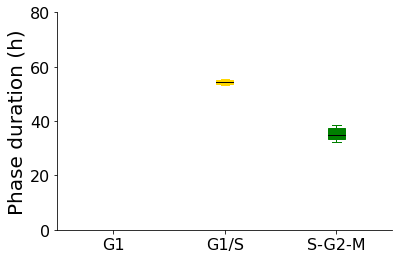

In [76]:
# Make boxplot
# if np_phase_length_list.shape[1] > 3:
#     G1 = np.concatenate((np_phase_length_list[::,0],np_phase_length_list[::,3]), axis = None)
# else:
G1 = np_phase_length_list[::,0] 
G1 = G1[np.logical_not(np.isnan(G1))]
G1S = np_phase_length_list[::,1] 
G1S = G1S[np.logical_not(np.isnan(G1S))]
G2 = np_phase_length_list[::,2]
G2 = G2[np.logical_not(np.isnan(G2))]

fig, ax = plt.subplots()

ax.boxplot(G1,labels=['G1'], positions=[1], patch_artist=True,
           boxprops=dict(facecolor = "red", color = "red"),
           capprops=dict(color="red"),
           whiskerprops=dict(color="red"),
           flierprops=dict(color="red", markeredgecolor="k"),
           medianprops=dict(color="k"))
ax.boxplot(G1S,labels=['G1/S'], positions=[2], patch_artist=True,
           boxprops=dict(facecolor = "gold", color = "gold"),
           capprops=dict(color="gold"),
           whiskerprops=dict(color="gold"),
           flierprops=dict(color="gold", markeredgecolor="k"),
           medianprops=dict(color="k"))
ax.boxplot(G2,labels=['S-G2-M'], positions=[3], patch_artist=True,
           boxprops=dict(facecolor = "green", color = "green"),
           capprops=dict(color="green"),
           whiskerprops=dict(color="green"),
           flierprops=dict(color="green", markeredgecolor="k"),
           medianprops=dict(color="k"))
ax.set_ylim(0,80)
ax.set_ylabel("Phase duration (h)", fontsize=20)
#ax.set_xlabel('Time (h)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
# if treatment == "Mock" and concentration == CONC6_init:
#     ax.set_title('100 nM E2', fontsize=24)
#     fig.savefig('Figures/MN10/FigXX_Phase_duration_Mock_conc6.pdf', bbox_inches='tight')
# elif treatment == "GREB1 KD":
#     ax.set_title('GREB1 knockdown', fontsize=24)
#     fig.savefig('Figures/MN10/Fig5X_Phase_duration_GREB1_KD.pdf', bbox_inches='tight')
# elif treatment == "PR KD":
#     ax.set_title('PR knockdown', fontsize=24)
#     fig.savefig('Figures/MN10/Fig5X_Phase_duration_PR_KD.pdf', bbox_inches='tight')



In [69]:
# Make data for combined boxplot
if treatment == "Mock":
    if concentration == CONC4_init:
        G1_conc4 = G1
        G1S_conc4 = G1S
        G2_conc4 = G2
    elif concentration == CONC6_init:
        G1_conc6 = G1
        G1S_conc6 = G1S
        G2_conc6 = G2
elif (treatment == "GREB1 KD") and (concentration == CONC6_init):
    G1_greb1kd = G1
    G1S_greb1kd = G1S
    G2_greb1kd = G2



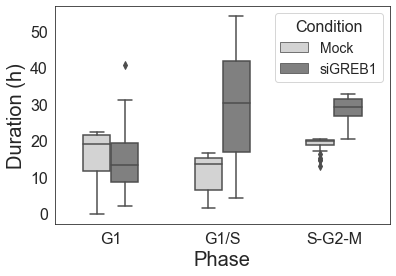

In [71]:
if (treatment == "Mock") and ("G1_conc4" in locals()) and ("G1_conc6" in locals()):
    # Make data
    d = {'Concentration': ["1 nM"]*len(G1_conc4) + ["1 nM"]*len(G1S_conc4) + ["1 nM"]*len(G2_conc4) + ["100 nM"]*len(G1_conc6) + ["100 nM"]*len(G1S_conc6) + ["100 nM"]*len(G2_conc6),
         'Concentration & phase': ["1 nM, G1"]*len(G1_conc4) + ["1 nM, G1/S"]*len(G1S_conc4) + ["1 nM, S-G2-M"]*len(G2_conc4) + ["100 nM, G1"]*len(G1_conc6) + ["100 nM, G1/S"]*len(G1S_conc6) + ["100 nM, S-G2-M"]*len(G2_conc6),
         'Phase': ["G1"]*len(G1_conc4) + ["G1/S"]*len(G1S_conc4) + ["S-G2-M"]*len(G2_conc4) + ["G1"]*len(G1_conc6) + ["G1/S"]*len(G1S_conc6) + ["S-G2-M"]*len(G2_conc6),
         'Duration': np.hstack((G1_conc4, G1S_conc4, G2_conc4, G1_conc6, G1S_conc6, G2_conc6)),
         'Colors': ["red"]*len(G1_conc4) + ["yellow"]*len(G1S_conc4) + ["green"]*len(G2_conc4) + ["darkred"]*len(G1_conc6) + ["gold"]*len(G1S_conc6) + ["darkgreen"]*len(G2_conc6)}

    data = pd.DataFrame(d)

    sns.set_style("white")
    ax = sns.boxplot(x = data['Phase'],
                y = data['Duration'],
                hue = data['Concentration'],
                palette = ["lightgrey","grey"], 
                saturation=1, width = 0.5)
    #sns.set(font_scale = 1)
    plt.xlabel('Phase', fontsize=20)
    plt.ylabel('Duration (h)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(title='E2 concentration', fontsize=14)
    plt.setp(ax.get_legend().get_title(), fontsize='16')

    plt.savefig('Figures/MN10/Fig3I_Phase_duration_two_concentrations.pdf', bbox_inches='tight')

elif (treatment == "GREB1 KD") and ("G1_greb1kd" in locals()) and ("G1_conc6" in locals()):
    # Make data
    d = {'Condition': ["Mock"]*len(G1_conc6) + ["Mock"]*len(G1S_conc6) + ["Mock"]*len(G2_conc6) + ["siGREB1"]*len(G1_greb1kd) + ["siGREB1"]*len(G1S_greb1kd) + ["siGREB1"]*len(G2_greb1kd),
         'Phase': ["G1"]*len(G1_conc6) + ["G1/S"]*len(G1S_conc6) + ["S-G2-M"]*len(G2_conc6) + ["G1"]*len(G1_greb1kd) + ["G1/S"]*len(G1S_greb1kd) + ["S-G2-M"]*len(G2_greb1kd),
         'Duration': np.hstack((G1_conc6, G1S_conc6, G2_conc6, G1_greb1kd, G1S_greb1kd, G2_greb1kd)),
         'Colors': ["red"]*len(G1_conc6) + ["yellow"]*len(G1S_conc6) + ["green"]*len(G2_conc6) + ["darkred"]*len(G1_greb1kd) + ["gold"]*len(G1S_greb1kd) + ["darkgreen"]*len(G2_greb1kd)}

    data = pd.DataFrame(d)

    sns.set_style("white")
    ax = sns.boxplot(x = data['Phase'],
                y = data['Duration'],
                hue = data['Condition'],
                palette = ["lightgrey","grey"], 
                saturation=1, width = 0.5)
    #sns.set(font_scale = 1)
    plt.xlabel('Phase', fontsize=20)
    plt.ylabel('Duration (h)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(title='Condition', fontsize=14)
    plt.setp(ax.get_legend().get_title(), fontsize='16')

    plt.savefig('Figures/MN10/Fig5E_Phase_duration_two_concentrations.pdf', bbox_inches='tight')



Make plots for entire protein expression pattern



In [56]:
# Get first sample with length longer than ~ 24 h
minimum_traj_length = 500
i = 0
while sample[i] < minimum_traj_length:
    i += 1


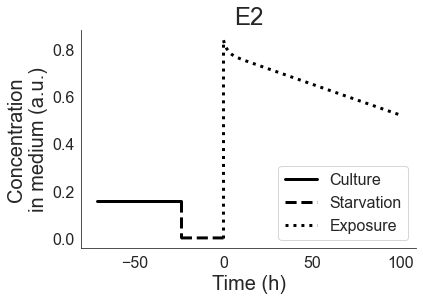

In [57]:
if concentration == CONC6_init:
    # Plot simulation results E2
    fig,ax = plt.subplots()
    tp1 = t_phase1[:sample[i]]
    sp0 = out_phase0[:,2]
    sp1 = out_phase1[:sample[i],2]
    sp3 = simus_phase3[0][:,2]
    sp4 = simus_phase4[0][:,2]
    if treatment == "GREB1 KD" or treatment == "PR KD":
        # time of phases
        tp2 = t_phase1[sample[i]] + t_phase2
        tp3 = t_phase1[sample[i]] + t_phase2[len(t_phase2)-1] + t_phase3
        tp4 = t_phase1[sample[i]] + t_phase2[len(t_phase2)-1] + t_phase3[len(t_phase3)-1] + t_phase4
        # simulations of phases
        sp2 = simus_phase2[0][:,2]
    else:
        tp3 = t_phase1[sample[i]] + t_phase3
        tp4 = t_phase1[sample[i]] + t_phase3[len(t_phase3)-1] + t_phase4    

    if treatment == "GREB1 KD" or treatment == "PR KD":
        ax.plot(tp1-tp4[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
        # Connect line sections
        ax.plot([tp2[0],tp2[0]]-tp4[0],[sp1[len(sp1)-1],sp2[0]], linestyle = 'solid', color = 'grey', linewidth = 3)
        ax.plot(tp2-tp4[0],sp2,label='siRNA transfection', linestyle = 'solid', color = 'grey', linewidth = 3)
        # Connect line sections
        ax.plot([tp3[0],tp3[0]]-tp4[0],[sp2[len(sp2)-1],sp3[0]], linestyle = 'dashed', color = 'k', linewidth = 3)
        ax.plot(tp3-tp4[0],sp3,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
        # Connect line sections
        ax.plot([tp4[0],tp4[0]]-tp4[0],[sp3[len(sp3)-1],sp4[0]], linestyle = 'dotted', color = 'k', linewidth = 3)
        ax.plot(tp4-tp4[0],sp4,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)
    else:
        ax.plot(tp1-tp4[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
        # Connect line sections
        ax.plot([tp3[0],tp3[0]]-tp4[0],[sp1[len(sp1)-1],sp3[0]], linestyle = 'dashed', color = 'k', linewidth = 3)
        ax.plot(tp3-tp4[0],sp3,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
        # Connect line sections
        ax.plot([tp4[0],tp4[0]]-tp4[0],[sp3[len(sp3)-1],sp4[0]], linestyle = 'dotted', color = 'k', linewidth = 3)
        ax.plot(tp4-tp4[0],sp4,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)
    ax.legend()
    ax.set_xlabel('Time (h)', fontsize=20)
    ax.set_ylabel('Concentration\nin medium (a.u.)', fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(loc='lower right', prop={'size': 16}) 
    if treatment == "Mock":
        ax.set_title('E2', fontsize=24)
        fig.savefig('Figures/MN10/Fig3D_E2_trajectory_Mock.pdf', bbox_inches='tight')

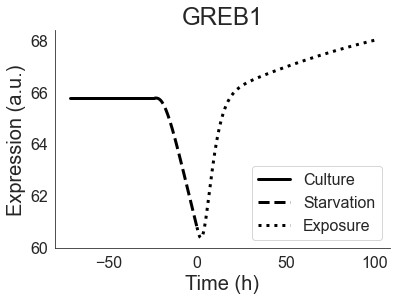

In [58]:
if concentration == CONC6_init:

    # Plot simulation results GREB1
    fig,ax = plt.subplots()
    tp1 = t_phase1[:sample[i]]
    sp0 = out_phase0[:,7] + out_phase0[:,8]
    sp1 = out_phase1[:sample[i],7] + out_phase1[:sample[i],8]
    sp3 = simus_phase3[0][:,7] + simus_phase3[0][:,8]
    sp4 = simus_phase4[0][:,7] + simus_phase4[0][:,8]
    if treatment == "GREB1 KD" or treatment == "PR KD":
        # time of phases
        tp2 = t_phase1[sample[i]] + t_phase2
        tp3 = t_phase1[sample[i]] + t_phase2[len(t_phase2)-1] + t_phase3
        tp4 = t_phase1[sample[i]] + t_phase2[len(t_phase2)-1] + t_phase3[len(t_phase3)-1] + t_phase4
        # simulations of phases
        sp2 = simus_phase2[0][:,7] + simus_phase2[0][:,8]
    else:
        tp3 = t_phase1[sample[i]] + t_phase3
        tp4 = t_phase1[sample[i]] + t_phase3[len(t_phase3)-1] + t_phase4    

    if treatment == "GREB1 KD" or treatment == "PR KD":
        ax.plot(tp1-tp4[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
        ax.plot(tp2-tp4[0],sp2,label='siRNA transfection', linestyle = 'solid', color = 'grey', linewidth = 3)
        ax.plot(tp3-tp4[0],sp3,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
        ax.plot(tp4-tp4[0],sp4,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)
    else:
        ax.plot(tp1-tp4[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
        ax.plot(tp3-tp4[0],sp3,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
        ax.plot(tp4-tp4[0],sp4,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)
    ax.legend()
    ax.set_xlabel('Time (h)', fontsize=20)
    ax.set_ylabel('Expression (a.u.)', fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(loc='lower right', prop={'size': 16}) 
    if treatment == "Mock":
        ax.set_title('GREB1', fontsize=24)
        fig.savefig('Figures/MN10/Fig3E_GREB1_trajectory_Mock.pdf', bbox_inches='tight')
    elif treatment == "GREB1 KD":
        ax.set_title('GREB1', fontsize=24)
        fig.savefig('Figures/MN10/FigSX_GREB1_trajectory_GREB1KD.pdf', bbox_inches='tight')
    elif treatment == "PR KD":
        ax.set_title('GREB1', fontsize=24)
        fig.savefig('Figures/MN10/FigSX_GREB1_trajectory_PRKD.pdf', bbox_inches='tight')



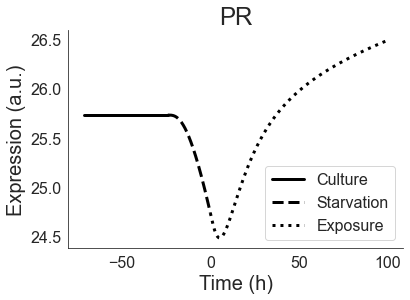

In [59]:
if concentration == CONC6_init:

    # Plot simulation results PR
    fig,ax = plt.subplots()
    tp1 = t_phase1[:sample[i]]
    sp0 = out_phase0[:,5] + out_phase0[:,6] + out_phase0[:,8]
    sp1 = out_phase1[:sample[i],5] + out_phase1[:sample[i],6] + out_phase1[:sample[i],8]
    sp3 = simus_phase3[0][:,5] + simus_phase3[0][:,6] + simus_phase3[0][:,8]
    sp4 = simus_phase4[0][:,5] + simus_phase4[0][:,6] + simus_phase4[0][:,8]
    if treatment == "GREB1 KD" or treatment == "PR KD":
        # time of phases
        tp2 = t_phase1[sample[i]] + t_phase2
        tp3 = t_phase1[sample[i]] + t_phase2[len(t_phase2)-1] + t_phase3
        tp4 = t_phase1[sample[i]] + t_phase2[len(t_phase2)-1] + t_phase3[len(t_phase3)-1] + t_phase4
        # simulations of phases
        sp2 = simus_phase2[0][:,5] + simus_phase2[0][:,6] + simus_phase2[0][:,8]
    else:
        tp3 = t_phase1[sample[i]] + t_phase3
        tp4 = t_phase1[sample[i]] + t_phase3[len(t_phase3)-1] + t_phase4    

    if treatment == "GREB1 KD" or treatment == "PR KD":
        ax.plot(tp1-tp4[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
        ax.plot(tp2-tp4[0],sp2,label='siRNA transfection', linestyle = 'solid', color = 'grey', linewidth = 3)
        ax.plot(tp3-tp4[0],sp3,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
        ax.plot(tp4-tp4[0],sp4,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)
    else:
        ax.plot(tp1-tp4[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
        ax.plot(tp3-tp4[0],sp3,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
        ax.plot(tp4-tp4[0],sp4,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)
    ax.legend()
    ax.set_xlabel('Time (h)', fontsize=20)
    ax.set_ylabel('Expression (a.u.)', fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(loc='lower right', prop={'size': 16}) 
    if treatment == "Mock":
        ax.set_title('PR', fontsize=24)
        fig.savefig('Figures/MN10/Fig3E_PR_trajectory_Mock.pdf', bbox_inches='tight')
    elif treatment == "GREB1 KD":
        ax.set_title('PR', fontsize=24)
        fig.savefig('Figures/MN10/FigSX_PR_trajectory_GREB1KD.pdf', bbox_inches='tight')
    elif treatment == "PR KD":
        ax.set_title('PR', fontsize=24)
        fig.savefig('Figures/MN10/FigSX_PR_trajectory_PRKD.pdf', bbox_inches='tight')


In [ ]:
#####################################

In [ ]:
# Plot simulation results CDK1
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,0],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],0],label='Phase 1', linestyle = 'solid')
if treatment == "GREB1 KD" or treatment == "PR KD":
    ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,0],label='Phase 2', linestyle = 'solid')
    ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,0],label='Phase 3', linestyle = 'solid')
    ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3[len(t_phase3)-1] + t_phase4,simus_phase4[0][:,0],label='Phase 4', linestyle = 'solid')
ax.legend()
ax.set_title("CDK1")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results APC
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,1],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],1],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,1],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,1],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("APC")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results E2
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,2],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],2],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,2],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,2],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("E2")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,3],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],3],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,3],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,3],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("ER")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,4],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],4],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,4],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,4],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("E2/ER")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results PR total
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,5] + out_phase0[:,6] + out_phase0[:,8],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],5] + out_phase1[:sample[0],6] + out_phase1[:sample[0],8], label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2, simus_phase2[0][:,5] + simus_phase2[0][:,6] + simus_phase2[0][:,8], label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3, simus_phase3[0][:,5] + simus_phase3[0][:,6] + simus_phase3[0][:,8],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("PR")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results PR total new

# fig,ax = plt.subplots()
# ax.plot(t_phase0,out_phase0[:,5] + out_phase0[:,6] + out_phase0[:,8],label='Phase 0', linestyle = 'solid')
# ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],5] + out_phase1[:sample[0],6] + out_phase1[:sample[0],8], label='Phase 1', linestyle = 'solid')
# ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2, simus_phase2[0][:,5] + simus_phase2[0][:,6] + simus_phase2[0][:,8], label='Phase 2', linestyle = 'solid')
# ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3, simus_phase3[0][:,5] + simus_phase3[0][:,6] + simus_phase3[0][:,8],label='Phase 3', linestyle = 'solid')

# ax.legend()
# ax.set_title("PR")
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Proteins')
fig,ax = plt.subplots()
tp1 = t_phase1[:sample[0]]
tp2 = t_phase1[sample[0]] + t_phase2
tp3 = t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3
sp0 = out_phase0[:,5] + out_phase0[:,6] + out_phase0[:,8]
sp1 = out_phase1[:sample[0],5] + out_phase1[:sample[0],6] + out_phase1[:sample[0],8]
sp2 = simus_phase2[0][:,5] + simus_phase2[0][:,6] + simus_phase2[0][:,8]
sp3 = simus_phase3[0][:,5] + simus_phase3[0][:,6] + simus_phase3[0][:,8]
#ax.plot(tp0,sp0,label='Phase 0', linestyle = 'solid')
ax.plot(tp1-tp3[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
ax.plot(tp2-tp3[0],sp2,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
ax.plot(tp3-tp3[0],sp3,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)

ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('Expression (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='lower right', prop={'size': 16}) 
# if treatment == "Mock":
#     ax.set_title('PR', fontsize=24)
#     fig.savefig('Figures/MN10/Fig3E_PR_trajectory_Mock.pdf', bbox_inches='tight')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,6],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],6],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,6],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,6],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("E2/ER/PR")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,8],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],8],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,8],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,8],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("E2/ER/PR transformed")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,7],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],7],label='Phase 1', linestyle = 'solid')
if treatment == "GREB1 KD" or treatment == "PR KD":
    ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,7],label='Phase 2', linestyle = 'solid')
    ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,7],label='Phase 3', linestyle = 'solid')
    ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3[len(t_phase3)-1] + t_phase4,simus_phase4[0][:,7],label='Phase 4', linestyle = 'solid')
ax.legend()
ax.set_title("GREB1")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

fig,ax = plt.subplots()
tp1 = t_phase1[:sample[0]]
tp2 = t_phase1[sample[0]] + t_phase2
tp3 = t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3
sp0 = out_phase0[:,7]
sp1 = out_phase1[:sample[0],7]
sp2 = simus_phase2[0][:,7]
sp3 = simus_phase3[0][:,7]
#ax.plot(tp0,sp0,label='Phase 0', linestyle = 'solid')
ax.plot(tp1-tp3[0],sp1,label='Culture', linestyle = 'solid', color = 'k', linewidth = 3)
ax.plot(tp2-tp3[0],sp2,label='Starvation', linestyle = 'dashed', color = 'k', linewidth = 3)
ax.plot(tp3-tp3[0],sp3,label='Exposure', linestyle = 'dotted', color = 'k', linewidth = 3)

ax.set_xlabel('Time (h)', fontsize=20)
ax.set_ylabel('Expression (a.u.)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(loc='lower right', prop={'size': 16}) 
# if treatment == "Mock":
#     ax.set_title('GREB1', fontsize=24)
#     fig.savefig('Figures/MN10/Fig3E_GREB1_trajectory_Mock.pdf', bbox_inches='tight')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase0,out_phase0[:,9],label='Phase 0', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[:sample[0]],out_phase1[:sample[0],9],label='Phase 1', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2,simus_phase2[0][:,9],label='Phase 2', linestyle = 'solid')
ax.plot(t_phase0[len(t_phase0)-1] + t_phase1[sample[0]] + t_phase2[len(t_phase2)-1] + t_phase3,simus_phase3[0][:,9],label='Phase 3', linestyle = 'solid')

ax.legend()
ax.set_title("TFF1")
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



In [ ]:
# Phase 3 plotting

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,1],label='APC', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,2],label='E2', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,3],label='ER', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,2],label='E2', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,4],label='Ce2er', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,6],label='Ce2erpr', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,8],label='Ce2erprmod', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,5] + out_phase3[:,6] + out_phase3[:,8], label='PR', linestyle = 'solid') 
#ax.plot(t_phase3,out_phase3[:,9],label='TFF1', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3, out_phase3[:,7], label='GREB1', linestyle = 'solid') 
#ax.plot(t_phase3,out_phase3[:,9],label='TFF1', linestyle = 'solid')


ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



#######################
Phase two: starvation, in absence of E2
Test for one timepoint
#######################

In [ ]:
# Phase two: starvation, in absence of E2

# Model
def CellCycle_phase2(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1, Ce2erprmod, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * APC * k_e2er * Ce2er
    
    dE2 = 0
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprmod / (1 + Ce2erprmod) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - m_e2erpr * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 + stim_greb1 * Ce2erprmod *  GREB1 / (1 + Ce2erprmod + GREB1) - d_greb1 * GREB1
    dCe2erprmod = m_e2erpr * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprmod * Ce2erprmod
    
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprmod, dTFF1]

# Initial conditions
z_phase2 = np.hstack((out_phase1[out_phase1.shape[0]-1,0:2],0,out_phase1[out_phase1.shape[0]-1,3::])) # out_phase1[out_phase1.shape[0]-1,::]

# Make time range
timespan_phase2 = 24
timepoints_phase2 = 10000

# Phase 1 time span 
t_phase2 = np.linspace(0, timespan_phase2, timepoints_phase2)

# Run simulation
out_phase2 = odeint(CellCycle_phase2, z_phase2, t_phase2)

# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_phase2,out_phase2[:,1],label='APC', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,2],label='E2', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,3],label='ER', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,4],label='Ce2er', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,6],label='Ce2erpr', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,8],label='Ce2erprmod', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,2],label='E2', linestyle = 'solid')
ax.plot(t_phase2,out_phase2[:,4],label='Ce2er', linestyle = 'solid')
ax.plot(t_phase2,out_phase2[:,6],label='Ce2erpr', linestyle = 'solid')
ax.plot(t_phase2,out_phase2[:,8],label='Ce2erprmod', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2,out_phase2[:,5] + out_phase2[:,6] + out_phase2[:,8], label='PR', linestyle = 'solid') 
#ax.plot(t_phase2,out_phase2[:,9],label='TFF1', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase2, out_phase2[:,7], label='GREB1', linestyle = 'solid') 
#ax.plot(t_phase2,out_phase2[:,9],label='TFF1', linestyle = 'solid')


ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



Phase three: exposure to E2

In [ ]:
# Phase three: exposure to E2


# Model
def CellCycle_phase3(z,t):    
    
    # State vars
    CDK1, APC, E2, ER, Ce2er, PR, Ce2erpr, GREB1, Ce2erprmod, TFF1  = z
    
    # Cell cycling
    dCDK1  = a1 - b1 * CDK1 * APC**n1 / (K1**n1 + APC**n1) + a3 * (1 - CDK1) * (CDK1**n3 / (K3**n3 + CDK1**n3)) + k_greb1 * GREB1
    dAPC  =  a2 * (1 - APC) * CDK1**n2 / (K2**n2 + CDK1**n2) - b2  * APC * k_e2er * Ce2er
    
    dE2 = - b_e2er * E2 * ER / (1 + E2 + ER)
    dER = s_er - b_e2er * E2 * ER / (1 + E2 + ER) - d_er * ER 
    dCe2er = b_e2er * E2 * ER / (1 + E2 + ER) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_e2er * Ce2er

    # Formation of second complex
    dPR = s_pr + stim_pr * Ce2erprmod / (1 + Ce2erprmod) - b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - d_pr * PR 
    dCe2erpr = b_e2erpr * Ce2er * PR / (1 + Ce2er + PR) - m_e2erpr * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erpr * Ce2erpr

    # Formation of third complex
    dGREB1 = s_greb1 + stim_greb1 * Ce2erprmod *  GREB1 / (1 + Ce2erprmod + GREB1) - d_greb1 * GREB1
    dCe2erprmod = m_e2erpr * Ce2erpr * GREB1 / (1 + Ce2erpr + GREB1) - d_e2erprmod * Ce2erprmod
    
    dTFF1 = s_tff1 + stim_tff1 * Ce2er * PR / (1 + Ce2er + PR) - d_tff1 * TFF1

    return [dCDK1, dAPC, dE2, dER, dCe2er, dPR, dCe2erpr, dGREB1, dCe2erprmod, dTFF1]

# Initial conditions
z_phase3 = np.hstack((out_phase2[out_phase2.shape[0]-1,0:2],CONC2_init,out_phase2[out_phase2.shape[0]-1,3::])) # out_phase1[out_phase1.shape[0]-1,::]

# Make time range
timespan_phase3 = 100
timepoints_phase3 = 1000

# Phase 1 time span 
t_phase3 = np.linspace(0, timespan_phase3, timepoints_phase3)

# Run simulation
out_phase3 = odeint(CellCycle_phase3, z_phase3, t_phase3)

# Phase 1 plotting
# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,0],label='CDK1', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,1],label='APC', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,2],label='E2', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')


# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,3],label='ER', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,2],label='E2', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,4],label='Ce2er', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,6],label='Ce2erpr', linestyle = 'solid')
ax.plot(t_phase3,out_phase3[:,8],label='Ce2erprmod', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')

# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3,out_phase3[:,5] + out_phase3[:,6] + out_phase3[:,8], label='PR', linestyle = 'solid') 
#ax.plot(t_phase3,out_phase3[:,9],label='TFF1', linestyle = 'solid')

ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



# Plot simulation results
fig,ax = plt.subplots()
ax.plot(t_phase3, out_phase3[:,7], label='GREB1', linestyle = 'solid') 
#ax.plot(t_phase3,out_phase3[:,9],label='TFF1', linestyle = 'solid')


ax.legend()
ax.set_xlabel('Time (h)')
ax.set_ylabel('Proteins')



In [ ]:
#     # Merge maxima into one array
#     if len(x_maxima_CDK1) > 1 and len(x_maxima_CDK1) == len(x_maxima_APC):
#         maxima = [None] * (len(x_maxima_CDK1) + len(x_maxima_APC))
#         if x_maxima_CDK1[0] < x_maxima_APC[0]:
#             maxima[::2] = x_maxima_CDK1
#             maxima[1::2] = x_maxima_APC
#         else:
#             maxima[::2] = x_maxima_APC
#             maxima[1::2] = x_maxima_CDK1

#         maxima = np.array(maxima)/(timepoints_phase3/timespan_phase3)
        
#     elif len(x_maxima_CDK1) < len(x_maxima_APC):
#         maxima = [None] * (len(x_maxima_CDK1) + len(x_maxima_APC))
#         maxima[::2] = x_maxima_APC
#         maxima[1::2] = x_maxima_CDK1
#         maxima = np.array(maxima)/(timepoints_phase3/timespan_phase3)
        
#     elif len(x_maxima_CDK1) > len(x_maxima_APC) and (len(x_maxima_CDK1) + len(x_maxima_APC)) > 3:
#         maxima = [None] * (len(x_maxima_CDK1) + len(x_maxima_APC))
#         maxima[::2] = x_maxima_CDK1
#         maxima[1::2] = x_maxima_APC
#         maxima = np.array(maxima)/(timepoints_phase3/timespan_phase3)

#     elif len(x_maxima_CDK1) > len(x_maxima_APC) and (len(x_maxima_CDK1) + len(x_maxima_APC)) == 3:
#         maxima = [None] * (len(x_maxima_CDK1) + len(x_maxima_APC))
#         maxima[1] = x_maxima_APC[0]
#         maxima[::2] = x_maxima_CDK1
#         maxima = np.array(maxima)/(timepoints_phase3/timespan_phase3)

#     elif len(x_maxima_CDK1) == 1 and len(x_maxima_APC) == 1 and x_maxima_CDK1[0] < x_maxima_APC[0]:
#         maxima = [None] * (len(x_maxima_CDK1) + len(x_maxima_APC))
#         maxima[1] = x_maxima_APC[0]
#         maxima[0] = x_maxima_CDK1[0]
#         maxima = np.array(maxima)/(timepoints_phase3/timespan_phase3)
        
#     elif len(x_maxima_CDK1) == 1 and len(x_maxima_APC) == 1 and x_maxima_CDK1[0] > x_maxima_APC[0]:
#         maxima = [None] * (len(x_maxima_CDK1) + len(x_maxima_APC))
#         maxima[1] = x_maxima_CDK1[0]
#         maxima[0] = x_maxima_APC[0]
#         maxima = np.array(maxima)/(timepoints_phase3/timespan_phase3)
        
#     else:
#         warnings.warn("Too little maxima!")
    
#     print("Maxima:")
#     print(maxima)

